# Coursera
## Анализ данных: финальный проект
### Жёлтое такси в Нью-Йорке
#### Михалев Антон

# неделя 06

## исходные данные:
* страница со ссылками: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
* отдельные файлы:
    * за период с 2009-01 до 2019-06
        * https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2009-01.csv
        * ...
        * https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2019-06.csv
    
    * за период с 2019-07 до 2020-12
        * https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-07.csv
        * ...
        * https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2020-12.csv
    

* ссылка на kaggle - https://inclass.kaggle.com/c/yellowtaxi.

In [2]:
# !pip install pandas
# !pip install fsspec
# !pip install matplotlib
# !pip install scipy
# !pip install basemap
# !pip install folium

In [3]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar

from scipy import stats

import matplotlib.pyplot as plt

import itertools as it

import datetime as dt

import warnings

import gc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.statespace import sarimax

In [5]:
import tqdm

# вспомогательные функции
собраны в начало ноутбука, чтобы было удобнее перезапускать по частям

In [6]:
# тестовые отладочные параметры

__nrows_full = None
__nrows_10 = 10_000

# __nrows_week_01 = __nrows_full
# __nrows_week_01 = __nrows_10

__nrows_pipeline = __nrows_full
# __nrows_pipeline = __nrows_10

# __need_pipeline=True
__need_pipeline=False

# __need_pipeline_2016_05=True
__need_pipeline_2016_05=False
# __need_pipeline_2016_06=True
__need_pipeline_2016_06=False

# __need_save_year=True
__need_save_year=False

__need_load_year=True
# __need_load_year=False

__need_load_more_5=True
# __need_load_more_5=False

# __need_save_region=True
# __need_save_region=False

# __need_load_region=True
# __need_load_region=False

# __nrows_sarimax_fit = __nrows_full
# __nrows_sarimax_fit = 1_000

# __nrows_sarimax_grid = __nrows_full
__nrows_sarimax_grid = 1_000

__use_1_model = True
# __use_1_model = False

# __model_rows = __nrows_full
__model_rows = 5_000



In [7]:
N_pred = 6

K = 23
K_d = 4
stat_len = 24
sum_list = [12, 24, 24*7, 24*7*4] # полдня, сутки, неделю, месяц
near_len = 24

skip_begin = K_d * 24
skip_end = K


In [8]:
new_york_coords = {
    'west': -74.25559, 
    'east': -73.70001, 
    'north': 40.91553, 
    'south': 40.49612, 
}


In [9]:
empire_state_building_region = 1231

In [10]:
# получаем список имен файлов по списку годов/месяцев

s3_amazonaws_com_nyc_tlc_link = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'
nyc_tlc_s3_amazonaws_com_link = 'https://nyc-tlc.s3.amazonaws.com/trip+data/'
local_folder = '../data/'

def get_names(use_local, dates):
    result = []
    for year, month in dates:
        if use_local:
            result.append(f'{local_folder}yellow_tripdata_{year}-{month:02}.csv')
        else:
            result.append(f'{nyc_tlc_s3_amazonaws_com_link}yellow_tripdata_{year}-{month:02}.csv')
    
    return result
        

In [11]:
# загружаем весь список файлов в один длинный дата-фрейм

def load_data(names, nrows=None, columns=[]):
    result = None
    
    for i, name in enumerate(names):
        print(f'{i+1}/{len(names)}:{name}')
        
        load_df = pd.read_csv(name, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], nrows=nrows)        
        load_df = drop_columns_except(load_df, columns=columns)
        
        if result is None:
            result = load_df
        else:
            result = pd.concat([
                result, 
                load_df
            ])
    return result

In [12]:
# удаляем колонки, за исключением указанных

def drop_columns_except(data, columns):
    data.drop(columns=list(set(data.columns) - set(columns)), inplace=True)
    return data


In [13]:
# чистим данные

def clear_data(data):
    data.drop(data
              [
                (data['tpep_dropoff_datetime'] == data['tpep_pickup_datetime']) |    
                (data['passenger_count'] <= 0) |    
                (data['trip_distance'] <= 0) |    
                (data['pickup_longitude'] < new_york_coords['west']) | (data['pickup_longitude'] > new_york_coords['east']) |
                (data['pickup_latitude'] < new_york_coords['south']) | (data['pickup_latitude'] > new_york_coords['north'])
              ].index, inplace=True)
    
    return data


In [14]:
# округляем время до часов

def round_time(data):
    data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].dt.floor("H")
    return data

In [15]:
# считаем статистику по регионам

def calc_bins(data, bins):
    bins_result = stats.binned_statistic_2d(data['pickup_longitude'], data['pickup_latitude'], 
                                        None, 
                                        statistic='count', 
                                        bins=bins,
                                        expand_binnumbers=True,
                                       )
    data['region'] = (bins_result.binnumber[0] - 1) * 50 + bins_result.binnumber[1]
    
    return data

In [16]:
# считаем групповую статистику по регионам и часам

def calc_aggregated(data):
    result_aggregated = data.groupby(["tpep_pickup_datetime", "region"]).size().to_frame(name='count')
    result_aggregated['passenger_count'] = data.groupby(["tpep_pickup_datetime", "region"])['passenger_count'].sum()
    
    return result_aggregated

In [17]:
# расширяем групповую статистику до полного набора всех возможных значений

def expand_aggregated(data_aggregated, datetime_all, region_all):
    all_product = pd.DataFrame([[x0, y0] for x0 in datetime_all for y0 in region_all], columns=['tpep_pickup_datetime', 'region'])
    all_product.set_index(['tpep_pickup_datetime', 'region'], inplace=True)
    all_product['count_dummy'] = None
    
    data_aggregated_all = all_product.join(data_aggregated)
    
    data_aggregated_all.drop(columns=['count_dummy'], inplace=True)
    
    data_aggregated_all.fillna(0, inplace=True)
    
    data_aggregated_all.reset_index(inplace=True)

    return data_aggregated_all

In [18]:
# полный цикл обработки для заданного списка файлов

def full_pipeline(names, nrows, bins, data_regions):
    print('(-/6) pipeline begin...')

    result = load_data(names, nrows=nrows, columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'pickup_longitude', 'pickup_latitude', 'passenger_count', 'trip_distance'])
    print('(1/6) load_data end...')

    result = clear_data(result)
    result = drop_columns_except(result, ['tpep_pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'passenger_count'])
    print('(2/6) clear_data end...')
    
    result = round_time(result)
    print('(3/6) round_time end...')
    
    result = calc_bins(result, bins=bins)
    result = drop_columns_except(result, ['tpep_pickup_datetime', 'region', 'passenger_count'])
    print('(4/6) calc_bins end...')
    
    result_aggregated = calc_aggregated(result)
    print('(5/6) calc_aggregated end...')
        
    result_aggregated_expanded = expand_aggregated(result_aggregated, result_aggregated.index.unique(level='tpep_pickup_datetime'), data_regions['region'].unique())
    result_aggregated_expanded = drop_columns_except(result_aggregated_expanded, ['tpep_pickup_datetime', 'region', 'count', 'passenger_count'])
    print('(6/6) expand_aggregated end...')
    
    print('(-/-) pipeline end...')
    return result_aggregated_expanded


In [19]:
def calc_date_columns(df, column_prefix=None):
    date_columns = []
    
    column_name = 'date_year'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.year
    date_columns.append(column_name)

    column_name = 'date_month'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.month
    date_columns.append(column_name)

    column_name = 'date_day'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.day
    date_columns.append(column_name)

    column_name = 'date_dayofweek'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.dayofweek
    date_columns.append(column_name)

    column_name = 'date_hour'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = df.index.hour
    date_columns.append(column_name)
    
    return df, date_columns


In [20]:
from sklearn.preprocessing import OneHotEncoder

def calc_one_hot_fit_transform(df, column_list):    
    one_hot_columns = []
    one_hot_encoders = {}

    for column_name_original in column_list:
        one_hot_encoders[column_name_original] = OneHotEncoder(handle_unknown='ignore')

        one_hot_encoders[column_name_original].fit(df[column_name_original].values.reshape(-1, 1))
        one_hot_result = one_hot_encoders[column_name_original].transform(df[column_name_original].values.reshape(-1, 1))
        
        for i in range(one_hot_result.shape[1]):
            column_name_one_hot = f'{column_name_original}_{i}'
            df[column_name_one_hot] = one_hot_result[:, i].toarray()
            
            one_hot_columns.append(column_name_one_hot)
        
    return df, one_hot_columns, one_hot_encoders


def calc_one_hot_transform(df, column_list, one_hot_encoders):    
    one_hot_columns = []

    for column_name_original in column_list:
        one_hot_result = one_hot_encoders[column_name_original].transform(df[column_name_original].values.reshape(-1, 1))
        
        for i in range(one_hot_result.shape[1]):
            column_name_one_hot = f'{column_name_original}_{i}'
            df[column_name_one_hot] = one_hot_result[:, i].toarray()
            
            one_hot_columns.append(column_name_one_hot)
        
    return df, one_hot_columns



In [21]:
def add_t_sin_cos(df, k=15, start_t=0, column_prefix=None):
    period_list = [1, 7, 12, 24, 24*7, 24*7*4, 365]
    
    column_t = 't'
    if column_prefix is not None:
        column_t = (column_prefix, column_t)
    
    harmonic_columns = [column_t]
    
    t = np.array(range(start_t, start_t + len(df)))
    df[column_t] = t    
    
    for period in period_list:
        for i in range(1, k+1):
            column_name = f'sin_{i}_{period}'
            if column_prefix is not None:
                column_name = (column_prefix, column_name)
            harmonic_columns.append(column_name)
            df[column_name] = np.sin(df[column_t] * 2 * np.pi * i / period)

            column_name = f'cos_{i}_{period}'
            if column_prefix is not None:
                column_name = (column_prefix, column_name)
            harmonic_columns.append(column_name)
            df[column_name] = np.cos(df[column_t] * 2 * np.pi * i / period)
        
    return df, harmonic_columns


In [22]:
def calc_lags(df, pivot_regions, K, K_d, N_pred, stat_len, sum_list=[]):
    for region_current in tqdm.tqdm(pivot_regions):
        columns_lag_plus = []
        columns_lag_minus = []
        columns_lag_sum = []
        columns_lag_stat = []

        column_name_count = (region_current, f'count')

        for i in range(1, N_pred + 1):
            column_name_lag = f'lag_plus_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            columns_lag_plus.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_count].shift(-i)

        for i in range(1, K + 1):
            column_name_lag = f'lag_minus_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            columns_lag_minus.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_count].shift(i)

        for i in range(1, K_d + 1):
            column_name_lag = f'lag_minus_{i * 24}'
            column_name_lag_full = (region_current, column_name_lag)
            columns_lag_minus.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_count].shift(i * 24)

        for i in sum_list:
            column_name_lag = f'lag_sum_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            columns_lag_sum.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_count].rolling(i).sum()
            df_pivot[column_name_lag_full].fillna(value=df_pivot[column_name_count].cumsum(), inplace=True)

        column_name_lag = f'lag_mean_{stat_len}'
        column_name_lag_full = (region_current, column_name_lag)
        columns_lag_stat.append(column_name_lag)
        df_pivot[column_name_lag_full] = df_pivot[column_name_count].rolling(stat_len).mean()
        
        column_name_lag = f'lag_median_{stat_len}'
        column_name_lag_full = (region_current, column_name_lag)
        columns_lag_stat.append(column_name_lag)
        df_pivot[column_name_lag_full] = df_pivot[column_name_count].rolling(stat_len).median()
        
        column_name_lag = f'lag_std_{stat_len}'
        column_name_lag_full = (region_current, column_name_lag)
        columns_lag_stat.append(column_name_lag)
        df_pivot[column_name_lag_full] = df_pivot[column_name_count].rolling(stat_len).std()
                
    return df, columns_lag_plus, columns_lag_minus, columns_lag_sum, columns_lag_stat


In [23]:
def add_arima_lags_plus(df, df_arima, lags_count, region_n, column_prefix):
    columns_lag_plus = []
    
    for i in range(1, lags_count + 1):
        column_name_lag = f'{column_prefix}_lag_plus_{i}'
        column_name_lag_full = (region_n, column_name_lag)
        columns_lag_plus.append(column_name_lag)
        df[column_name_lag_full] = df_arima.shift(-i)
        
    return df, columns_lag_plus
        
        
def add_arima(df, df_arima, pivot_regions):
    arima_columns = []

    new_column_name_linear_sin_cos_predict = 'linear_sin_cos_predict'
    new_column_name_sarimax = 'sarimax'
    new_column_name_full_predict = 'full_predict'
    
    arima_columns.append(new_column_name_linear_sin_cos_predict)
    arima_columns.append(new_column_name_sarimax)
    arima_columns.append(new_column_name_full_predict)

    for region_current in tqdm.tqdm(pivot_regions):
        old_column_name_linear_sin_cos_predict = f'region_{region_current}_linear_sin_cos_predict'
        df[(region_current, new_column_name_linear_sin_cos_predict)] = df_arima[old_column_name_linear_sin_cos_predict]
        df, columns_lag_plus = add_arima_lags_plus(df, df_arima[old_column_name_linear_sin_cos_predict], lags_count=N_pred, region_n=region_current, column_prefix=new_column_name_linear_sin_cos_predict)
        for column in columns_lag_plus:
            if column not in arima_columns:
                arima_columns.append(column)

        old_column_name_sarimax = f'region_{region_current}_sarimax'
        df[(region_current, new_column_name_sarimax)] = df_arima[old_column_name_sarimax]
        df, columns_lag_plus = add_arima_lags_plus(df, df_arima[old_column_name_sarimax], lags_count=N_pred, region_n=region_current, column_prefix=new_column_name_sarimax)
        for column in columns_lag_plus:
            if column not in arima_columns:
                arima_columns.append(column)

        old_column_name_full_predict = f'region_{region_current}_full_predict'
        df[(region_current, new_column_name_full_predict)] = df_arima[old_column_name_full_predict]
        df, columns_lag_plus = add_arima_lags_plus(df, df_arima[old_column_name_full_predict], lags_count=N_pred, region_n=region_current, column_prefix=new_column_name_full_predict)
        for column in columns_lag_plus:
            if column not in arima_columns:
                arima_columns.append(column)
        
    return df, arima_columns


In [24]:
def calc_holiday_columns(df, start, end, column_prefix=None):
    holiday_columns = []
    
    calendar = USFederalHolidayCalendar()
    holidays = calendar.holidays(start=start, end=end) 

    column_name = 'holiday'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = np.isin(df.index.date, holidays.date).astype(int)
    holiday_columns.append(column_name)

    column_name = 'holiday_minus_1'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = np.isin(df.index.date, holidays.date - dt.timedelta(days = - 1)).astype(int)
    holiday_columns.append(column_name)

    column_name = 'holiday_plus_1'
    if column_prefix is not None:
        column_name = (column_prefix, column_name)        
    df[column_name] = np.isin(df.index.date, holidays.date - dt.timedelta(days = + 1)).astype(int)
    holiday_columns.append(column_name)

    return df, holiday_columns


In [25]:
def get_regions_near(region_n, row_count, col_count):
    all_count = row_count * col_count
    result = []
    
    if (region_n + 1) < all_count:
        result.append(region_n + 1)
        
    if (region_n + col_count) < all_count:
        result.append(region_n + col_count)

    if (region_n + col_count - 1) < all_count:
        result.append(region_n + col_count - 1)

    if (region_n + col_count + 1) < all_count:
        result.append(region_n + col_count + 1)

    if (region_n - 1) >= 0:
        result.append(region_n - 1)
        
    if (region_n - col_count) >= 0:
        result.append(region_n - col_count)

    if (region_n - col_count - 1) >= 0:
        result.append(region_n - col_count - 1)

    if (region_n - col_count + 1) >= 0:
        result.append(region_n - col_count + 1)
    
    return result

In [26]:
def calc_lags_near(df, pivot_regions, row_count, col_count, near_len, sum_list=[]):
    columns_lag_near = []
    
    for region_current in tqdm.tqdm(pivot_regions):
        columns_near = [(region_near, f'count') for region_near in np.unique(get_regions_near(region_current, row_count, col_count))]

        for lag_i in range(0, near_len + 1):
            for near_i in range(len(columns_near)):
                column_name_lag = f'lag_near_{near_i+1}_minus_{lag_i}'
                column_name_lag_full = (region_current, column_name_lag)
                if column_name_lag not in columns_lag_near:
                    columns_lag_near.append(column_name_lag)

                df_pivot[column_name_lag_full] = df_pivot[columns_near[near_i]].shift(lag_i)

            column_name_lag = f'lag_near_sum_minus_{lag_i}'
            column_name_lag_full = (region_current, column_name_lag)
            if column_name_lag not in columns_lag_near:
                columns_lag_near.append(column_name_lag)

            df_pivot[column_name_lag_full] = df_pivot[columns_near].shift(lag_i).sum(axis=1)
                
        for i in sum_list:
            column_name_lag_data = (region_current, f'lag_near_sum_minus_0')

            column_name_lag = f'lag_near_sum_sum_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            if column_name_lag not in columns_lag_near:
                columns_lag_near.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_lag_data].rolling(i).sum()
            df_pivot[column_name_lag_full].fillna(value=df_pivot[column_name_lag_data].cumsum(), inplace=True)

            column_name_lag = f'lag_near_sum_mean_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            if column_name_lag not in columns_lag_near:
                columns_lag_near.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_lag_data].rolling(i).mean()

            column_name_lag = f'lag_near_sum_median_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            if column_name_lag not in columns_lag_near:
                columns_lag_near.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_lag_data].rolling(i).median()

            column_name_lag = f'lag_near_sum_std_{i}'
            column_name_lag_full = (region_current, column_name_lag)
            if column_name_lag not in columns_lag_near:
                columns_lag_near.append(column_name_lag)
            df_pivot[column_name_lag_full] = df_pivot[column_name_lag_data].rolling(i).std()

    return df, columns_lag_near


In [27]:
def unpivot_table(df, common_columns, pivot_regions):
    result = None


    for region_current in tqdm.tqdm(pivot_regions):
        df_new = df[common_columns].copy()
        
        pivot_region_columns = [column for column in df.columns if column[0] == region_current]
        unpivot_region_columns = [('region', column[1]) for column in df.columns if column[0] == region_current]
        
        df_new[('region', 'id')] = region_current
        df_new[unpivot_region_columns] = df[pivot_region_columns]
        
        if result is None:
            result = df_new
        else:
            result = result.append(df_new)
            
    unpivot_region_columns_dict = {
        'id': ('region', 'id'),
        'count': ('region', 'count'),               
        'lags': [c for c in unpivot_region_columns if c != ('region', 'count')],
        'all': [('region', 'id')] + unpivot_region_columns,
    }
            
    return result, common_columns, unpivot_region_columns_dict


In [28]:
def create_submission(result):
    df = []
    for region_n, region_result in result.items():
        for history_end, history_result in region_result.items():
            submission_date_time = datetime.datetime.strftime(history_end, '%Y-%m-%d_%#H')
            for pred_n, pred_value in enumerate(history_result):
                df.append([f'{region_n}_{submission_date_time}_{pred_n + 1}', pred_value]) 

    return pd.DataFrame(df, columns=['id', 'y'])
                           

In [29]:
# https://www.kaggle.com/wittmannf/aula-2-awari

## Memory optimization

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


## предсказания ARIMA с предыдущей недели 

In [30]:
df_regions_with_2016_05 = pd.read_csv('df_regions_with_2016_05.csv', parse_dates=['tpep_pickup_datetime'], index_col='tpep_pickup_datetime')
df_regions_with_2016_05

,region_1075_linear_sin_cos_predict,region_1075_sarimax,region_1075_full_predict,region_1076_linear_sin_cos_predict,region_1076_sarimax,region_1076_full_predict,region_1077_linear_sin_cos_predict,region_1077_sarimax,region_1077_full_predict,region_1125_linear_sin_cos_predict,...,region_2069_full_predict,region_2118_linear_sin_cos_predict,region_2118_sarimax,region_2118_full_predict,region_2119_linear_sin_cos_predict,region_2119_sarimax,region_2119_full_predict,region_2168_linear_sin_cos_predict,region_2168_sarimax,region_2168_full_predict
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,34.674200,NaN,NaN,43.898419,NaN,NaN,21.464275,NaN,NaN,43.137808,...,NaN,65.352004,NaN,NaN,27.797134,NaN,NaN,33.292883,NaN,NaN
2015-01-01 01:00:00,18.697536,NaN,NaN,17.197645,NaN,NaN,-0.211476,NaN,NaN,24.300168,...,NaN,48.954936,NaN,NaN,20.214479,NaN,NaN,22.299691,NaN,NaN
2015-01-01 02:00:00,6.440231,NaN,NaN,1.057018,NaN,NaN,-9.017017,NaN,NaN,11.597221,...,NaN,38.448682,NaN,NaN,14.212284,NaN,NaN,15.134856,NaN,NaN
2015-01-01 03:00:00,0.062375,NaN,NaN,-0.852805,NaN,NaN,-3.006860,NaN,NaN,7.187862,...,NaN,34.319196,NaN,NaN,10.417452,NaN,NaN,12.864398,NaN,NaN
2015-01-01 04:00:00,0.524540,NaN,NaN,12.192005,NaN,NaN,16.298624,NaN,NaN,11.340110,...,NaN,35.801883,NaN,NaN,9.039405,NaN,NaN,15.393181,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31 19:00:00,80.291843,20.319649,100.611492,147.419974,47.835283,195.255257,120.799818,54.235303,175.035121,95.458823,...,13.360984,167.076064,33.012108,200.088172,46.441257,5.695722,52.136980,80.057626,17.444130,97.501756
2016-05-31 20:00:00,79.423587,20.309067,99.732654,144.459121,11.925466,156.384587,120.581465,28.357656,148.939121,95.787542,...,17.922702,160.495948,77.032472,237.528420,44.540554,29.707225,74.247778,82.322763,35.701188,118.023951
2016-05-31 21:00:00,74.056096,29.987703,104.043799,131.492561,38.958816,170.451377,107.526874,11.486969,119.013843,88.296478,...,10.959011,147.088821,28.078968,175.167789,40.081102,20.361610,60.442712,79.106447,52.591164,131.697610


In [31]:
print(df_regions_with_2016_05.info())
df_regions_with_2016_05 = reduce_mem_usage(df_regions_with_2016_05)
print(df_regions_with_2016_05.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12408 entries, 2015-01-01 00:00:00 to 2016-05-31 23:00:00
Columns: 306 entries, region_1075_linear_sin_cos_predict to region_2168_full_predict
dtypes: float64(306)
memory usage: 29.1 MB
None
Memory usage of dataframe is 29.06 MB
Memory usage after optimization is: 14.58 MB
Decreased by 49.8%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12408 entries, 2015-01-01 00:00:00 to 2016-05-31 23:00:00
Columns: 306 entries, region_1075_linear_sin_cos_predict to region_2168_full_predict
dtypes: float32(306)
memory usage: 14.6 MB
None


In [32]:
df_regions_with_2016_05['region_2168_full_predict'].isna().sum()

744

In [33]:
df_2016_06_102_regions = pd.read_csv('df_2016_06_102_regions.csv', parse_dates=['tpep_pickup_datetime'], index_col='tpep_pickup_datetime')
df_2016_06_102_regions

,region_1075_linear_sin_cos_predict,region_1075_sarimax,region_1075_full_predict,region_1076_linear_sin_cos_predict,region_1076_sarimax,region_1076_full_predict,region_1077_linear_sin_cos_predict,region_1077_sarimax,region_1077_full_predict,region_1125_linear_sin_cos_predict,...,region_2069_full_predict,region_2118_linear_sin_cos_predict,region_2118_sarimax,region_2118_full_predict,region_2119_linear_sin_cos_predict,region_2119_sarimax,region_2119_full_predict,region_2168_linear_sin_cos_predict,region_2168_sarimax,region_2168_full_predict
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-01 00:00:00,34.091169,-6.426442,27.664727,46.793650,-6.297638,40.496012,21.438921,-0.234324,21.204597,33.289162,...,6.588861,86.404430,82.080344,168.484774,17.440802,2.722560,20.163362,45.272786,62.637942,107.910728
2016-06-01 01:00:00,19.047263,-9.132764,9.914500,19.740906,-4.946092,14.794814,-2.076595,-1.929912,-4.006507,15.465690,...,3.905313,68.908598,10.246835,79.155433,10.077397,-1.119112,8.958285,33.240464,26.391446,59.631910
2016-06-01 02:00:00,7.526746,-7.049433,0.477312,3.354054,-0.871942,2.482112,-12.743958,-1.534748,-14.278706,4.034388,...,1.386719,56.783336,-34.977447,21.805890,4.389947,5.611523,10.001471,24.781125,-7.034827,17.746298
2016-06-01 03:00:00,1.662953,-7.000056,-5.337103,1.612179,-0.816548,0.795632,-7.950167,-0.534516,-8.484683,1.043718,...,0.371953,50.911634,-30.350340,20.561293,0.911086,4.257331,5.168417,21.214111,-9.156547,12.057564
2016-06-01 04:00:00,2.478838,-4.838803,-2.359965,15.443760,-10.169736,5.274024,11.252452,-5.617420,5.635032,6.615958,...,0.256158,50.920284,-37.376013,13.544271,-0.246439,5.524737,5.278298,22.653327,-9.736827,12.916501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,87.353195,18.323002,105.676196,149.881378,35.546510,185.427889,114.469388,26.142040,140.611428,101.800315,...,13.081922,178.464547,19.229245,197.693792,45.230889,-0.380354,44.850535,77.882136,5.168807,83.050943
2016-06-30 20:00:00,87.576261,14.959959,102.536221,146.437694,25.913166,172.350860,111.452832,20.539004,131.991836,104.842938,...,13.430065,170.968432,70.857723,241.826154,44.202366,22.707528,66.909894,78.623984,16.156339,94.780323
2016-06-30 21:00:00,83.203837,22.512355,105.716192,134.854617,38.214205,173.068822,98.282964,7.597471,105.880435,100.753096,...,12.127711,156.490028,20.587235,177.077264,40.666735,13.676776,54.343511,74.475884,28.282288,102.758172


In [34]:
print(df_2016_06_102_regions.info())
df_2016_06_102_regions = reduce_mem_usage(df_2016_06_102_regions)
print(df_2016_06_102_regions.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2016-06-01 00:00:00 to 2016-06-30 23:00:00
Columns: 306 entries, region_1075_linear_sin_cos_predict to region_2168_full_predict
dtypes: float64(306)
memory usage: 1.7 MB
None
Memory usage of dataframe is 1.69 MB
Memory usage after optimization is: 0.85 MB
Decreased by 49.8%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2016-06-01 00:00:00 to 2016-06-30 23:00:00
Columns: 306 entries, region_1075_linear_sin_cos_predict to region_2168_full_predict
dtypes: float32(306)
memory usage: 866.2 KB
None


In [35]:
df_2016_06_102_regions.isna().sum().sum()

0

In [36]:
df_arima_predict = pd.concat([df_regions_with_2016_05, df_2016_06_102_regions])
df_arima_predict

,region_1075_linear_sin_cos_predict,region_1075_sarimax,region_1075_full_predict,region_1076_linear_sin_cos_predict,region_1076_sarimax,region_1076_full_predict,region_1077_linear_sin_cos_predict,region_1077_sarimax,region_1077_full_predict,region_1125_linear_sin_cos_predict,...,region_2069_full_predict,region_2118_linear_sin_cos_predict,region_2118_sarimax,region_2118_full_predict,region_2119_linear_sin_cos_predict,region_2119_sarimax,region_2119_full_predict,region_2168_linear_sin_cos_predict,region_2168_sarimax,region_2168_full_predict
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,34.674202,NaN,NaN,43.898418,NaN,NaN,21.464275,NaN,NaN,43.137810,...,NaN,65.352005,NaN,NaN,27.797134,NaN,NaN,33.292881,NaN,NaN
2015-01-01 01:00:00,18.697536,NaN,NaN,17.197645,NaN,NaN,-0.211476,NaN,NaN,24.300167,...,NaN,48.954937,NaN,NaN,20.214479,NaN,NaN,22.299692,NaN,NaN
2015-01-01 02:00:00,6.440231,NaN,NaN,1.057018,NaN,NaN,-9.017016,NaN,NaN,11.597220,...,NaN,38.448681,NaN,NaN,14.212284,NaN,NaN,15.134856,NaN,NaN
2015-01-01 03:00:00,0.062375,NaN,NaN,-0.852805,NaN,NaN,-3.006860,NaN,NaN,7.187862,...,NaN,34.319195,NaN,NaN,10.417452,NaN,NaN,12.864398,NaN,NaN
2015-01-01 04:00:00,0.524540,NaN,NaN,12.192004,NaN,NaN,16.298624,NaN,NaN,11.340110,...,NaN,35.801884,NaN,NaN,9.039405,NaN,NaN,15.393181,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,87.353195,18.323002,105.676193,149.881378,35.546509,185.427887,114.469391,26.142040,140.611435,101.800316,...,13.081923,178.464554,19.229246,197.693787,45.230888,-0.380354,44.850536,77.882133,5.168807,83.050941
2016-06-30 20:00:00,87.576263,14.959959,102.536224,146.437698,25.913166,172.350861,111.452835,20.539003,131.991837,104.842941,...,13.430065,170.968430,70.857719,241.826157,44.202366,22.707527,66.909897,78.623985,16.156340,94.780319
2016-06-30 21:00:00,83.203835,22.512354,105.716194,134.854614,38.214207,173.068817,98.282967,7.597471,105.880432,100.753098,...,12.127711,156.490036,20.587234,177.077271,40.666737,13.676776,54.343510,74.475883,28.282288,102.758171


In [37]:
print(df_arima_predict.info())
df_arima_predict = reduce_mem_usage(df_arima_predict)
print(df_arima_predict.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13128 entries, 2015-01-01 00:00:00 to 2016-06-30 23:00:00
Columns: 306 entries, region_1075_linear_sin_cos_predict to region_2168_full_predict
dtypes: float32(306)
memory usage: 15.4 MB
None
Memory usage of dataframe is 15.42 MB
Memory usage after optimization is: 15.42 MB
Decreased by 0.0%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13128 entries, 2015-01-01 00:00:00 to 2016-06-30 23:00:00
Columns: 306 entries, region_1075_linear_sin_cos_predict to region_2168_full_predict
dtypes: float32(306)
memory usage: 15.4 MB
None


In [38]:
len(df_arima_predict), len(df_arima_predict.index.unique())

(13128, 13128)

In [39]:
len(df_arima_predict.columns) / 3

102.0

## регионы

In [40]:
data_regions = pd.read_csv(local_folder + 'regions.csv', sep=';')
data_regions

,region,west,east,south,north
0,1,-74.255590,-74.244478,40.496120,40.504508
1,2,-74.255590,-74.244478,40.504508,40.512896
2,3,-74.255590,-74.244478,40.512896,40.521285
3,4,-74.255590,-74.244478,40.521285,40.529673
4,5,-74.255590,-74.244478,40.529673,40.538061
...,...,...,...,...,...
2495,2496,-73.711122,-73.700010,40.873589,40.881977
2496,2497,-73.711122,-73.700010,40.881977,40.890365
2497,2498,-73.711122,-73.700010,40.890365,40.898754
2498,2499,-73.711122,-73.700010,40.898754,40.907142


In [41]:
# data_regions['west'].value_counts()
# data_regions['east'].value_counts()
# data_regions['south'].value_counts()
# data_regions['north'].value_counts()

In [42]:
# data_regions['west'].unique()
# data_regions['east'].unique()
# data_regions['south'].unique()
# data_regions['north'].unique()

In [43]:
len(data_regions['west'].unique()), len(data_regions['east'].unique()), len(data_regions['south'].unique()), len(data_regions['north'].unique())

(50, 50, 50, 50)

In [44]:
set(data_regions['west'].unique()) - set(data_regions['east'].unique())

{-74.25559}

In [45]:
set(data_regions['south'].unique()) - set(data_regions['north'].unique())

{40.49612}

In [46]:
x_bins = data_regions['west'].append(data_regions['east']).unique()
y_bins = data_regions['south'].append(data_regions['north']).unique()

len(x_bins), len(y_bins)

(51, 51)

### проверим, совпадает ли мой список зон с kaggle

In [47]:
data_sample_solution = pd.read_csv(f'sample_solution.csv')
data_sample_solution['region'] = data_sample_solution['id'].str[:4].astype(int)
len(set(data_sample_solution['region']))

102

In [48]:
data_may = pd.read_csv(f'may.csv')
data_may['region'] = data_may['id'].str[:4].astype(int)
len(set(data_may['region']))

102

In [49]:
set(data_sample_solution['region']) - set(data_may['region'])

set()

In [50]:
# data_sample_solution['region'][0], 

In [51]:
regions_102 = sort(list(set(data_may['region'])))
len(regions_102), regions_102

(102,
 array([1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132,
        1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182,
        1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229, 1230,
        1231, 1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280,
        1281, 1282, 1283, 1284, 1285, 1286, 1287, 1326, 1327, 1331, 1332,
        1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377, 1378, 1380,
        1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431,
        1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1480, 1482, 1483,
        1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734, 1783, 2068, 2069,
        2118, 2119, 2168]))

### Вывод:
* регионы совпадают

## возьмем для обучения полный 2015-й год + январь-апрель 2016 

In [52]:
train_period = '2015-01_2016-04'

In [53]:
dates = [(2015, m) for m in range(1, 12+1)] + [(2016, m) for m in range(1, 4+1)]
dates

[(2015, 1),
 (2015, 2),
 (2015, 3),
 (2015, 4),
 (2015, 5),
 (2015, 6),
 (2015, 7),
 (2015, 8),
 (2015, 9),
 (2015, 10),
 (2015, 11),
 (2015, 12),
 (2016, 1),
 (2016, 2),
 (2016, 3),
 (2016, 4)]

In [54]:
get_names(use_local=True, dates=dates)

['../data/yellow_tripdata_2015-01.csv',
 '../data/yellow_tripdata_2015-02.csv',
 '../data/yellow_tripdata_2015-03.csv',
 '../data/yellow_tripdata_2015-04.csv',
 '../data/yellow_tripdata_2015-05.csv',
 '../data/yellow_tripdata_2015-06.csv',
 '../data/yellow_tripdata_2015-07.csv',
 '../data/yellow_tripdata_2015-08.csv',
 '../data/yellow_tripdata_2015-09.csv',
 '../data/yellow_tripdata_2015-10.csv',
 '../data/yellow_tripdata_2015-11.csv',
 '../data/yellow_tripdata_2015-12.csv',
 '../data/yellow_tripdata_2016-01.csv',
 '../data/yellow_tripdata_2016-02.csv',
 '../data/yellow_tripdata_2016-03.csv',
 '../data/yellow_tripdata_2016-04.csv']

In [55]:
if __need_pipeline:
    data_result = full_pipeline(get_names(use_local=True, dates=dates),
                              nrows=__nrows_pipeline,
                              bins=[x_bins, y_bins],
                              data_regions=data_regions
                             )
    data_result

In [56]:
if __need_save_year:
    data_result.to_csv(f'data_{train_period}.csv', index=False)

In [57]:
if __need_load_year:
    data_result = pd.read_csv(f'data_{train_period}.csv', parse_dates=['tpep_pickup_datetime'])
    
    data_result

In [58]:
data_train = data_result

In [59]:
data_train

,tpep_pickup_datetime,region,count,passenger_count
0,2015-01-01 00:00:00,1,0.0,0.0
1,2015-01-01 00:00:00,2,0.0,0.0
2,2015-01-01 00:00:00,3,0.0,0.0
3,2015-01-01 00:00:00,4,0.0,0.0
4,2015-01-01 00:00:00,5,0.0,0.0
...,...,...,...,...
29159995,2016-04-30 23:00:00,2496,0.0,0.0
29159996,2016-04-30 23:00:00,2497,0.0,0.0
29159997,2016-04-30 23:00:00,2498,0.0,0.0
29159998,2016-04-30 23:00:00,2499,0.0,0.0


In [60]:
print(data_train.info())
data_train = reduce_mem_usage(data_train)
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29160000 entries, 0 to 29159999
Data columns (total 4 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[ns]
 1   region                int64         
 2   count                 float64       
 3   passenger_count       float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 889.9 MB
None
Memory usage of dataframe is 889.89 MB
Memory usage after optimization is: 500.56 MB
Decreased by 43.7%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29160000 entries, 0 to 29159999
Data columns (total 4 columns):
 #   Column                Dtype         
---  ------                -----         
 0   tpep_pickup_datetime  datetime64[ns]
 1   region                int16         
 2   count                 float32       
 3   passenger_count       float32       
dtypes: datetime64[ns](1), float32(2), int16(1)
memory usage: 500.6 MB
None


In [61]:
data_train.set_index('tpep_pickup_datetime', inplace=True)
data_train

,region,count,passenger_count
tpep_pickup_datetime,,,
2015-01-01 00:00:00,1,0.0,0.0
2015-01-01 00:00:00,2,0.0,0.0
2015-01-01 00:00:00,3,0.0,0.0
2015-01-01 00:00:00,4,0.0,0.0
2015-01-01 00:00:00,5,0.0,0.0
...,...,...,...
2016-04-30 23:00:00,2496,0.0,0.0
2016-04-30 23:00:00,2497,0.0,0.0
2016-04-30 23:00:00,2498,0.0,0.0


In [62]:
len(data_train['region'].unique()), data_train['region'].unique()

(2500, array([   1,    2,    3, ..., 2498, 2499, 2500], dtype=int16))

In [63]:
len(data_train.index.unique()), data_train.index.unique()

(11664,
 DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
                '2015-01-01 02:00:00', '2015-01-01 03:00:00',
                '2015-01-01 04:00:00', '2015-01-01 05:00:00',
                '2015-01-01 06:00:00', '2015-01-01 07:00:00',
                '2015-01-01 08:00:00', '2015-01-01 09:00:00',
                ...
                '2016-04-30 14:00:00', '2016-04-30 15:00:00',
                '2016-04-30 16:00:00', '2016-04-30 17:00:00',
                '2016-04-30 18:00:00', '2016-04-30 19:00:00',
                '2016-04-30 20:00:00', '2016-04-30 21:00:00',
                '2016-04-30 22:00:00', '2016-04-30 23:00:00'],
               dtype='datetime64[ns]', name='tpep_pickup_datetime', length=11664, freq=None))

## для визуальной проверки - посмотрим на регион из предыдущего задания

In [64]:
empire_state_building_region

1231

In [65]:
count_region = data_train[data_train['region'] == empire_state_building_region]['count']
count_region

tpep_pickup_datetime
2015-01-01 00:00:00    821.0
2015-01-01 01:00:00    691.0
2015-01-01 02:00:00    565.0
2015-01-01 03:00:00    573.0
2015-01-01 04:00:00    417.0
                       ...  
2016-04-30 19:00:00    892.0
2016-04-30 20:00:00    779.0
2016-04-30 21:00:00    793.0
2016-04-30 22:00:00    884.0
2016-04-30 23:00:00    785.0
Name: count, Length: 11664, dtype: float32

In [66]:
count_region.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2016-04-30 14:00:00', '2016-04-30 15:00:00',
               '2016-04-30 16:00:00', '2016-04-30 17:00:00',
               '2016-04-30 18:00:00', '2016-04-30 19:00:00',
               '2016-04-30 20:00:00', '2016-04-30 21:00:00',
               '2016-04-30 22:00:00', '2016-04-30 23:00:00'],
              dtype='datetime64[ns]', name='tpep_pickup_datetime', length=11664, freq=None)

<AxesSubplot:xlabel='tpep_pickup_datetime'>

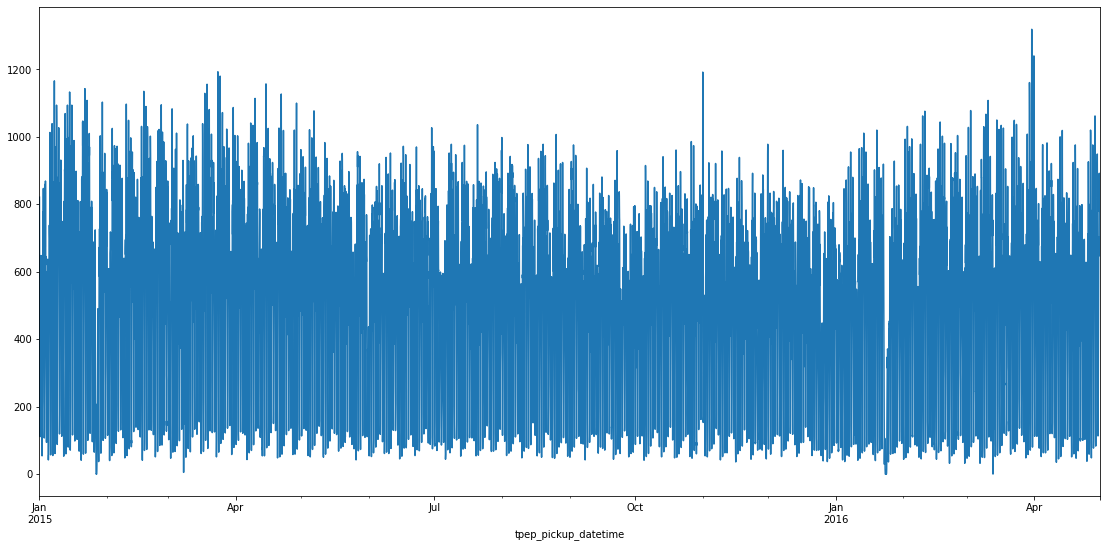

In [67]:
count_region.plot(figsize=(19, 9))

In [68]:
count_region.sum()

6085612.0

<AxesSubplot:>

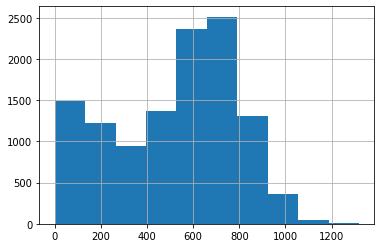

In [69]:
count_region.hist()

### Вывод:
* визуально графики совпадают с тем, что было

## возьмем для теста - май 2016, 
## для валидации - июнь 2016 

In [70]:
%%time

test_period = '2016-05'
dates = [(2016, 5)]


# 
data_2016_05 = full_pipeline(get_names(use_local=True, dates=dates),
                          nrows=__nrows_pipeline,
                          bins=[x_bins, y_bins],
                          data_regions=data_regions
                         )
data_2016_05.to_csv(f'data_{test_period}.csv', index=False)
# 


if __need_pipeline_2016_05:
    data_2016_05 = full_pipeline(get_names(use_local=True, dates=dates),
                              nrows=__nrows_pipeline,
                              bins=[x_bins, y_bins],
                              data_regions=data_regions
                             )
    data_2016_05.to_csv(f'data_{test_period}.csv', index=False)
else:
    data_2016_05 = pd.read_csv(f'data_{test_period}.csv', parse_dates=['tpep_pickup_datetime'])
    
data_2016_05.set_index('tpep_pickup_datetime', inplace=True)

data_2016_05

# Wall time: 2min 5s

(-/6) pipeline begin...
1/1:../data/yellow_tripdata_2016-05.csv
(1/6) load_data end...
(2/6) clear_data end...
(3/6) round_time end...
(4/6) calc_bins end...
(5/6) calc_aggregated end...
(6/6) expand_aggregated end...
(-/-) pipeline end...
Wall time: 2min 45s


,region,count,passenger_count
tpep_pickup_datetime,,,
2016-05-01 00:00:00,1,0.0,0.0
2016-05-01 00:00:00,2,0.0,0.0
2016-05-01 00:00:00,3,0.0,0.0
2016-05-01 00:00:00,4,0.0,0.0
2016-05-01 00:00:00,5,0.0,0.0
...,...,...,...
2016-05-31 23:00:00,2496,0.0,0.0
2016-05-31 23:00:00,2497,0.0,0.0
2016-05-31 23:00:00,2498,0.0,0.0


In [71]:
print(data_2016_05.info())
data_2016_05 = reduce_mem_usage(data_2016_05)
print(data_2016_05.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1860000 entries, 2016-05-01 00:00:00 to 2016-05-31 23:00:00
Data columns (total 3 columns):
 #   Column           Dtype  
---  ------           -----  
 0   region           int64  
 1   count            float64
 2   passenger_count  float64
dtypes: float64(2), int64(1)
memory usage: 56.8 MB
None
Memory usage of dataframe is 56.76 MB
Memory usage after optimization is: 31.93 MB
Decreased by 43.8%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1860000 entries, 2016-05-01 00:00:00 to 2016-05-31 23:00:00
Data columns (total 3 columns):
 #   Column           Dtype  
---  ------           -----  
 0   region           int16  
 1   count            float32
 2   passenger_count  float32
dtypes: float32(2), int16(1)
memory usage: 31.9 MB
None


In [72]:
len(data_2016_05['region'].unique()), data_2016_05['region'].unique()

(2500, array([   1,    2,    3, ..., 2498, 2499, 2500], dtype=int16))

In [73]:
%%time

test_period = '2016-06'
dates = [(2016, 6)]


# 
data_2016_06 = full_pipeline(get_names(use_local=True, dates=dates),
                          nrows=__nrows_pipeline,
                          bins=[x_bins, y_bins],
                          data_regions=data_regions
                         )
data_2016_06.to_csv(f'data_{test_period}.csv', index=False)
# 


if __need_pipeline_2016_06:
    data_2016_06 = full_pipeline(get_names(use_local=True, dates=dates),
                              nrows=__nrows_pipeline,
                              bins=[x_bins, y_bins],
                              data_regions=data_regions
                             )
    data_2016_06.to_csv(f'data_{test_period}.csv', index=False)
else:
    data_2016_06 = pd.read_csv(f'data_{test_period}.csv', parse_dates=['tpep_pickup_datetime'])
    
data_2016_06.set_index('tpep_pickup_datetime', inplace=True)

data_2016_06

# Wall time: 2min 5s

(-/6) pipeline begin...
1/1:../data/yellow_tripdata_2016-06.csv
(1/6) load_data end...
(2/6) clear_data end...
(3/6) round_time end...
(4/6) calc_bins end...
(5/6) calc_aggregated end...
(6/6) expand_aggregated end...
(-/-) pipeline end...
Wall time: 2min 21s


,region,count,passenger_count
tpep_pickup_datetime,,,
2016-06-01 00:00:00,1,0.0,0.0
2016-06-01 00:00:00,2,0.0,0.0
2016-06-01 00:00:00,3,0.0,0.0
2016-06-01 00:00:00,4,0.0,0.0
2016-06-01 00:00:00,5,0.0,0.0
...,...,...,...
2016-06-30 23:00:00,2496,0.0,0.0
2016-06-30 23:00:00,2497,0.0,0.0
2016-06-30 23:00:00,2498,0.0,0.0


In [74]:
print(data_2016_06.info())
data_2016_06 = reduce_mem_usage(data_2016_06)
print(data_2016_06.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1800000 entries, 2016-06-01 00:00:00 to 2016-06-30 23:00:00
Data columns (total 3 columns):
 #   Column           Dtype  
---  ------           -----  
 0   region           int64  
 1   count            float64
 2   passenger_count  float64
dtypes: float64(2), int64(1)
memory usage: 54.9 MB
None
Memory usage of dataframe is 54.93 MB
Memory usage after optimization is: 30.90 MB
Decreased by 43.8%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1800000 entries, 2016-06-01 00:00:00 to 2016-06-30 23:00:00
Data columns (total 3 columns):
 #   Column           Dtype  
---  ------           -----  
 0   region           int16  
 1   count            float32
 2   passenger_count  float32
dtypes: float32(2), int16(1)
memory usage: 30.9 MB
None


In [75]:
len(data_2016_06['region'].unique()), data_2016_06['region'].unique()

(2500, array([   1,    2,    3, ..., 2498, 2499, 2500], dtype=int16))

### найдем ячейки "которые были отобраны на второй неделе":
* "отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся"
* правильный ответ: 102

In [76]:
if __need_load_more_5:
    data_2016_05_more_5 = pd.read_csv(f'data_2016_05_more_5.csv')
    data_2016_05_more_5

In [77]:
print(data_2016_05_more_5.info())
data_2016_05_more_5 = reduce_mem_usage(data_2016_05_more_5)
print(data_2016_05_more_5.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   region  102 non-null    int64  
 1   month   102 non-null    object 
 2   count   102 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.5+ KB
None
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 62.8%
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   region  102 non-null    int16   
 1   month   102 non-null    category
 2   count   102 non-null    float32 
dtypes: category(1), float32(1), int16(1)
memory usage: 958.0 bytes
None


In [78]:
len(set(data_2016_05_more_5['region']))

102

In [79]:
region_102 = pd.Series(data_2016_05_more_5['region'].unique(), name='region')
region_102

0      1075
1      1076
2      1077
3      1125
4      1126
       ... 
97     2068
98     2069
99     2118
100    2119
101    2168
Name: region, Length: 102, dtype: int16

### добавим близлежащие соседние регионы

In [80]:
region_102_and_near = []

row_count = 50
col_count = 50

for region_n in region_102.values:
    region_102_and_near.append(region_n)    
    region_102_and_near.extend(get_regions_near(region_n, row_count, col_count))

region_102_and_near = pd.Series(np.unique(region_102_and_near), name='region')

len(region_102_and_near), region_102_and_near

(219,
 0      1024
 1      1025
 2      1026
 3      1027
 4      1028
        ... 
 214    2169
 215    2170
 216    2217
 217    2218
 218    2219
 Name: region, Length: 219, dtype: int32)

## соберем train + test + val в один большой датасет

In [81]:
data_all = data_train[data_train['region'].isin(region_102_and_near)].append(data_2016_05[data_2016_05['region'].isin(region_102_and_near)]).append(data_2016_06[data_2016_06['region'].isin(region_102_and_near)])
    
data_all

,region,count,passenger_count
tpep_pickup_datetime,,,
2015-01-01 00:00:00,1024,0.0,0.0
2015-01-01 00:00:00,1025,0.0,0.0
2015-01-01 00:00:00,1026,0.0,0.0
2015-01-01 00:00:00,1027,0.0,0.0
2015-01-01 00:00:00,1028,0.0,0.0
...,...,...,...
2016-06-30 23:00:00,2169,0.0,0.0
2016-06-30 23:00:00,2170,0.0,0.0
2016-06-30 23:00:00,2217,0.0,0.0


In [82]:
data_all['count'].sum()

160601550.0

In [83]:
print(data_all.info())
data_all = reduce_mem_usage(data_all)
print(data_all.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2875032 entries, 2015-01-01 00:00:00 to 2016-06-30 23:00:00
Data columns (total 3 columns):
 #   Column           Dtype  
---  ------           -----  
 0   region           int16  
 1   count            float32
 2   passenger_count  float32
dtypes: float32(2), int16(1)
memory usage: 49.4 MB
None
Memory usage of dataframe is 49.35 MB
Memory usage after optimization is: 49.35 MB
Decreased by 0.0%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2875032 entries, 2015-01-01 00:00:00 to 2016-06-30 23:00:00
Data columns (total 3 columns):
 #   Column           Dtype  
---  ------           -----  
 0   region           int16  
 1   count            float32
 2   passenger_count  float32
dtypes: float32(2), int16(1)
memory usage: 49.4 MB
None


In [84]:
len(data_all.index.unique()), len(data_train.index.unique()) +len(data_2016_05.index.unique()) + len(data_2016_06.index.unique()),  

(13128, 13128)

In [85]:
len(data_all['region'].unique()), len(region_102_and_near), len(region_102.unique()),

(219, 219, 102)

In [86]:
len(df_arima_predict), len(df_arima_predict.index.unique())

(13128, 13128)

### соберем сводную таблицу в нужном формате

In [87]:
data_all

,region,count,passenger_count
tpep_pickup_datetime,,,
2015-01-01 00:00:00,1024,0.0,0.0
2015-01-01 00:00:00,1025,0.0,0.0
2015-01-01 00:00:00,1026,0.0,0.0
2015-01-01 00:00:00,1027,0.0,0.0
2015-01-01 00:00:00,1028,0.0,0.0
...,...,...,...
2016-06-30 23:00:00,2169,0.0,0.0
2016-06-30 23:00:00,2170,0.0,0.0
2016-06-30 23:00:00,2217,0.0,0.0


In [88]:
df_pivot = data_all.pivot(columns=['region'], values=['count', 'passenger_count'])
df_pivot.fillna(0, inplace=True)
df_pivot

count                                                     \
region                1024 1025 1026 1027 1028 1074   1075   1076   1077 1078   
tpep_pickup_datetime                                                            
2015-01-01 00:00:00    0.0  0.0  0.0  0.0  0.0  0.0   78.0   89.0   44.0  1.0   
2015-01-01 01:00:00    0.0  0.0  0.0  0.0  1.0  0.0  105.0  122.0   42.0  2.0   
2015-01-01 02:00:00    0.0  0.0  0.0  0.0  0.0  0.0   80.0  122.0   26.0  3.0   
2015-01-01 03:00:00    0.0  0.0  0.0  0.0  1.0  0.0   52.0   81.0   14.0  2.0   
2015-01-01 04:00:00    0.0  0.0  0.0  0.0  0.0  1.0   19.0   40.0   11.0  1.0   
...                    ...  ...  ...  ...  ...  ...    ...    ...    ...  ...   
2016-06-30 19:00:00    0.0  0.0  0.0  0.0  0.0  0.0  116.0  190.0  135.0  2.0   
2016-06-30 20:00:00    0.0  0.0  0.0  1.0  0.0  0.0  104.0  142.0  149.0  0.0   
2016-06-30 21:00:00    0.0  0.0  0.0  0.0  0.0  0.0  151.0  162.0  145.0  2.0   
2016-06-30 22:00:00    0.0  0.0  0.0  0.0  0.0  0.0  106.0  168.0  103.0  1.0   
2016-06-30 23:00:00    0.0  0.0  0.0  0.0  0.0  0.0   85.0  130.0   86.0  2.0   

                      ... passenger_count                                   \
region                ...            2118   2119 2120 2167  2168 2169 2170   
tpep_pickup_datetime  ...                                                    
2015-01-01 00:00:00   ...           139.0    7.0  0.0  0.0  89.0  0.0  0.0   
2015-01-01 01:00:00   ...           140.0    0.0  0.0  0.0   1.0  0.0  0.0   
2015-01-01 02:00:00   ...             4.0    0.0  0.0  0.0   0.0  0.0  0.0   
2015-01-01 03:00:00   ...            30.0    0.0  0.0  0.0   0.0  0.0  0.0   
2015-01-01 04:00:00   ...             6.0    0.0  0.0  0.0  27.0  0.0  0.0   
...                   ...             ...    ...  ...  ...   ...  ...  ...   
2016-06-30 19:00:00   ...           240.0  165.0  0.0  0.0   6.0  0.0  0.0   
2016-06-30 20:00:00   ...           351.0  267.0  0.0  0.0   0.0  0.0  0.0   
2016-06-30 21:00:00   ...           360.0  235.0  0.0  0.0   1.0  0.0  0.0   
2016-06-30 22:00:00   ...           346.0  256.0  0.0  0.0   0.0  0.0  0.0   
2016-06-30 23:00:00   ...           313.0  231.0  0.0  0.0   0.0  0.0  0.0   

                                     
region               2217 2218 2219  
tpep_pickup_datetime                 
2015-01-01 00:00:00   0.0  0.0  0.0  
2015-01-01 01:00:00   0.0  0.0  0.0  
2015-01-01 02:00:00   0.0  0.0  0.0  
2015-01-01 03:00:00   0.0  0.0  0.0  
2015-01-01 04:00:00   0.0  0.0  0.0  
...                   ...  ...  ...  
2016-06-30 19:00:00   0.0  0.0  0.0  
2016-06-30 20:00:00   0.0  0.0  0.0  
2016-06-30 21:00:00   0.0  0.0  0.0  
2016-06-30 22:00:00   0.0  0.0  0.0  
2016-06-30 23:00:00   0.0  0.0  0.0  

[13128 rows x 438 columns]

In [89]:
df_pivot.isna().sum().sum()

0

In [90]:
print(df_pivot.info())
df_pivot = reduce_mem_usage(df_pivot)
print(df_pivot.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13128 entries, 2015-01-01 00:00:00 to 2016-06-30 23:00:00
Columns: 438 entries, ('count', 1024) to ('passenger_count', 2219)
dtypes: float32(438)
memory usage: 22.0 MB
None
Memory usage of dataframe is 22.03 MB
Memory usage after optimization is: 22.03 MB
Decreased by 0.0%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13128 entries, 2015-01-01 00:00:00 to 2016-06-30 23:00:00
Columns: 438 entries, ('count', 1024) to ('passenger_count', 2219)
dtypes: float32(438)
memory usage: 22.0 MB
None


### проверим суммы с исходной таблицей

In [91]:
len(data_all.index.unique()), len(df_pivot), df_pivot.index

(13128,
 13128,
 DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
                '2015-01-01 02:00:00', '2015-01-01 03:00:00',
                '2015-01-01 04:00:00', '2015-01-01 05:00:00',
                '2015-01-01 06:00:00', '2015-01-01 07:00:00',
                '2015-01-01 08:00:00', '2015-01-01 09:00:00',
                ...
                '2016-06-30 14:00:00', '2016-06-30 15:00:00',
                '2016-06-30 16:00:00', '2016-06-30 17:00:00',
                '2016-06-30 18:00:00', '2016-06-30 19:00:00',
                '2016-06-30 20:00:00', '2016-06-30 21:00:00',
                '2016-06-30 22:00:00', '2016-06-30 23:00:00'],
               dtype='datetime64[ns]', name='tpep_pickup_datetime', length=13128, freq=None))

In [92]:
len(data_all['region'].unique()), len(df_pivot.columns), df_pivot.columns

(219,
 438,
 MultiIndex([(          'count', 1024),
             (          'count', 1025),
             (          'count', 1026),
             (          'count', 1027),
             (          'count', 1028),
             (          'count', 1074),
             (          'count', 1075),
             (          'count', 1076),
             (          'count', 1077),
             (          'count', 1078),
             ...
             ('passenger_count', 2118),
             ('passenger_count', 2119),
             ('passenger_count', 2120),
             ('passenger_count', 2167),
             ('passenger_count', 2168),
             ('passenger_count', 2169),
             ('passenger_count', 2170),
             ('passenger_count', 2217),
             ('passenger_count', 2218),
             ('passenger_count', 2219)],
            names=[None, 'region'], length=438))

In [93]:
df_pivot['count', empire_state_building_region]

tpep_pickup_datetime
2015-01-01 00:00:00     821.0
2015-01-01 01:00:00     691.0
2015-01-01 02:00:00     565.0
2015-01-01 03:00:00     573.0
2015-01-01 04:00:00     417.0
                        ...  
2016-06-30 19:00:00     968.0
2016-06-30 20:00:00     924.0
2016-06-30 21:00:00    1057.0
2016-06-30 22:00:00     903.0
2016-06-30 23:00:00     899.0
Name: (count, 1231), Length: 13128, dtype: float32

<AxesSubplot:xlabel='tpep_pickup_datetime'>

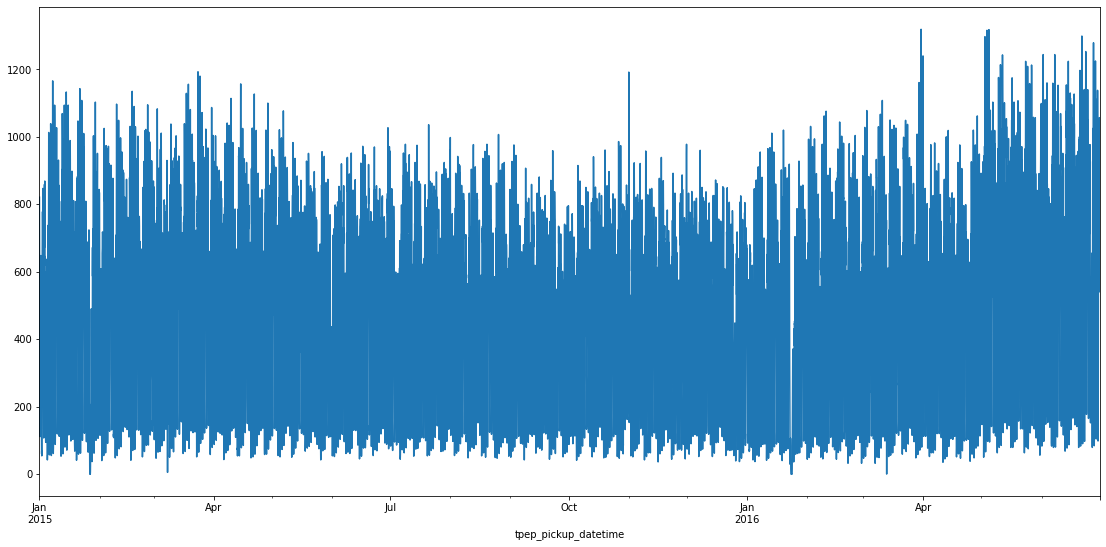

In [94]:
df_pivot['count', empire_state_building_region].plot(figsize=(19, 9))

<AxesSubplot:>

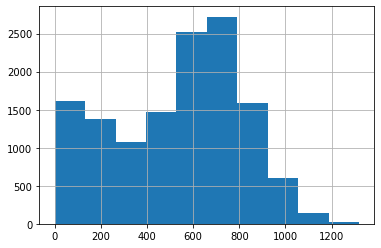

In [95]:
df_pivot['count', empire_state_building_region].hist()

In [96]:
df_pivot.sum().sum(), data_all['count'].sum()

(430284930.0, 160601550.0)

### Вывод:
* датасет составлен правильно

# Загрузите обучающие выборки прошлой недели, перечислите используемые в моделях признаки и посчитайте $Q_{may}$ — качество прогнозов моделей, настроенных на данных до апреля 2016, в мае 2016.

### признаки с прошлого занятия:

* год, месяц, день месяца, день недели, час
    * непрерывные
    * категориальные
* синусы, косинусы и тренды, которые использовали внутри регрессионной компоненты ARIMA
    * суточные/недельные/месячные/годовые гармоники с коэффициентами от 1 до 15
* сами значения прогнозов ARIMA $\hat{y}_{T+i|T}^{ARIMA} $
    * прогноз ARIMA непосредственно в каждой точке:
        * предсказание линейной регрессии (экзогенный признак для ARIMA)
        * предсказание ARIMA на остатки после линейной регрессии
        * итоговая сумма (линейная регрессия + ARIMA)
    * прогноз таких же данных на 6 лагов вперед
* количество поездок из рассматриваемого района в моменты времени 
    * K - назад (23)
    * K_d*24 - назад (4)
* суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
* идентификатор географической зоны — категориальный


# новые добавленные признаки:
* из сырых данных
    * passenger_count
* календарные
    * праздники
* географические
    * данные о поездках из 8 соседних ячеек:
        * 23 прошедших лага
        * сумма, среднее, медиана, дисперсия
* дополнительно
    * среднее, медиана, дисперсия по K предыдущим лагам


In [97]:
print(N_pred)

print(K, K_d)

print(sum_list)
print(stat_len)
print(near_len)

print(skip_begin, skip_end)


6
23 4
[12, 24, 168, 672]
24
24
96 23


In [98]:
common_columns = []
regression_columns = []
target_columns = []

### так как исходные данные для всех моделей одинаковы, а отличаются только отклики - будем хранить в одной матрице и исходные данные, и все 6 откликов

In [99]:
df_pivot.columns

MultiIndex([(          'count', 1024),
            (          'count', 1025),
            (          'count', 1026),
            (          'count', 1027),
            (          'count', 1028),
            (          'count', 1074),
            (          'count', 1075),
            (          'count', 1076),
            (          'count', 1077),
            (          'count', 1078),
            ...
            ('passenger_count', 2118),
            ('passenger_count', 2119),
            ('passenger_count', 2120),
            ('passenger_count', 2167),
            ('passenger_count', 2168),
            ('passenger_count', 2169),
            ('passenger_count', 2170),
            ('passenger_count', 2217),
            ('passenger_count', 2218),
            ('passenger_count', 2219)],
           names=[None, 'region'], length=438)

In [100]:
pivot_regions = np.unique([c[1] for c in df_pivot.columns])
pivot_regions

array([1024, 1025, 1026, 1027, 1028, 1074, 1075, 1076, 1077, 1078, 1079,
       1080, 1081, 1082, 1083, 1121, 1122, 1123, 1124, 1125, 1126, 1127,
       1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1170, 1171, 1172,
       1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183,
       1184, 1185, 1186, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227,
       1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1238,
       1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280,
       1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1321,
       1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332,
       1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1375, 1376,
       1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387,
       1388, 1389, 1390, 1391, 1392, 1393, 1425, 1426, 1427, 1428, 1429,
       1430, 1431, 1432, 1433, 1434, 1435, 1436, 1437, 1438, 1439, 1440,
       1441, 1442, 1443, 1475, 1476, 1477, 1479, 14

In [101]:
if df_pivot.columns[0][1] != 'count':
    df_pivot.columns = pd.MultiIndex.from_tuples([(c[1], 'count') if c[0] == 'count' else (c[1], 'passenger_count') for c in df_pivot.columns])
df_pivot

,1024,1025,1026,1027,1028,1074,1075,1076,1077,1078,...,2118,2119,2120,2167,2168,2169,2170,2217,2218,2219
,count,count,count,count,count,count,count,count,count,count,...,passenger_count,passenger_count,passenger_count,passenger_count,passenger_count,passenger_count,passenger_count,passenger_count,passenger_count,passenger_count
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,78.0,89.0,44.0,1.0,...,139.0,7.0,0.0,0.0,89.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00,0.0,0.0,0.0,0.0,1.0,0.0,105.0,122.0,42.0,2.0,...,140.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,80.0,122.0,26.0,3.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 03:00:00,0.0,0.0,0.0,0.0,1.0,0.0,52.0,81.0,14.0,2.0,...,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,1.0,19.0,40.0,11.0,1.0,...,6.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,0.0,0.0,0.0,0.0,0.0,0.0,116.0,190.0,135.0,2.0,...,240.0,165.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
2016-06-30 20:00:00,0.0,0.0,0.0,1.0,0.0,0.0,104.0,142.0,149.0,0.0,...,351.0,267.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
len(pivot_regions), pivot_regions[0], pivot_regions[-1]

(219, 1024, 2219)

### новые данные: 
* количество пассажиров

In [103]:
extra_columns = ['passenger_count']
# extra_columns

In [104]:
regression_columns.extend([('region', c) for c in extra_columns])
# regression_columns

### год, месяц, день месяца, день недели, час - непрерывные (данные с предыдущего занятия)

In [105]:
df_pivot, date_columns = calc_date_columns(df_pivot, column_prefix='COMMON')
# df_pivot[date_columns]

In [106]:
common_columns.extend(date_columns)
# common_columns

In [107]:
# df_pivot.columns

In [108]:
regression_columns.extend(date_columns)
# regression_columns

### новые данные: 
* праздники

In [109]:
df_pivot, holiday_columns = calc_holiday_columns(df_pivot, start=list(df_pivot.index)[0], end=list(df_pivot.index)[-1], column_prefix='COMMON')
df_pivot[holiday_columns]

COMMON                               
                     holiday holiday_minus_1 holiday_plus_1
tpep_pickup_datetime                                       
2015-01-01 00:00:00        1               0              0
2015-01-01 01:00:00        1               0              0
2015-01-01 02:00:00        1               0              0
2015-01-01 03:00:00        1               0              0
2015-01-01 04:00:00        1               0              0
...                      ...             ...            ...
2016-06-30 19:00:00        0               0              0
2016-06-30 20:00:00        0               0              0
2016-06-30 21:00:00        0               0              0
2016-06-30 22:00:00        0               0              0
2016-06-30 23:00:00        0               0              0

[13128 rows x 3 columns]

In [110]:
common_columns.extend(holiday_columns)
# common_columns

In [111]:
regression_columns.extend(holiday_columns)
# regression_columns

### синусы, косинусы и тренды, которые использовали внутри регрессионной компоненты ARIMA (данные с предыдущего занятия)

In [112]:
df_pivot, harmonic_columns = add_t_sin_cos(df_pivot, column_prefix='COMMON')
# df_pivot

In [113]:
common_columns.extend(harmonic_columns)
# len(common_columns)

In [114]:
regression_columns.extend(harmonic_columns)
# len(regression_columns)

### сами значения прогнозов ARIMA $\hat{y}_{T+i|T}^{ARIMA} $ (данные с предыдущего занятия)


In [115]:
df_pivot, arima_columns = add_arima(df_pivot, df_arima_predict, region_102, )
df_pivot.fillna(0, inplace=True)
# df_pivot

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:05<00:00, 19.17it/s]


In [116]:
arima_columns

['linear_sin_cos_predict',
 'sarimax',
 'full_predict',
 'linear_sin_cos_predict_lag_plus_1',
 'linear_sin_cos_predict_lag_plus_2',
 'linear_sin_cos_predict_lag_plus_3',
 'linear_sin_cos_predict_lag_plus_4',
 'linear_sin_cos_predict_lag_plus_5',
 'linear_sin_cos_predict_lag_plus_6',
 'sarimax_lag_plus_1',
 'sarimax_lag_plus_2',
 'sarimax_lag_plus_3',
 'sarimax_lag_plus_4',
 'sarimax_lag_plus_5',
 'sarimax_lag_plus_6',
 'full_predict_lag_plus_1',
 'full_predict_lag_plus_2',
 'full_predict_lag_plus_3',
 'full_predict_lag_plus_4',
 'full_predict_lag_plus_5',
 'full_predict_lag_plus_6']

### количество поездок из рассматриваемого района в моменты времени (данные с предыдущего занятия)
### + суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц (данные с предыдущего занятия)


### новые данные: 
* среднее, медиана, дисперсия по K предыдущим лагам

In [117]:
df_pivot, columns_lag_plus, columns_lag_minus, columns_lag_sum, columns_lag_stat = calc_lags(df_pivot, region_102, K, K_d, N_pred, stat_len, sum_list)
# df_pivot

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [00:19<00:00,  5.13it/s]


In [118]:
# columns_lag_plus, columns_lag_minus, columns_lag_sum, columns_lag_stat

### новые данные: 
* поездки из 8 соседних ячеек:
    * 23 прошедших лага
    * сумма, среднее, медиана, дисперсия

In [119]:
row_count = 50
col_count = 50

df_pivot, columns_lag_near = calc_lags_near(df_pivot, region_102, row_count, col_count, near_len=near_len, sum_list=[near_len])
# df_pivot

 15%|█████████████████▊                                                                                                       | 15/102 [02:44<15:56, 10.99s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



KeyboardInterrupt: 

### собираем обратно одномерную таблицу

In [120]:
print(df_pivot.info())
df_pivot = reduce_mem_usage(df_pivot)
print(df_pivot.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13128 entries, 2015-01-01 00:00:00 to 2016-06-30 23:00:00
Columns: 10367 entries, (1024, 'count') to (1176, 'lag_near_8_minus_5')
dtypes: float32(9374), float64(984), int32(4), int64(5)
memory usage: 568.8 MB
None
Memory usage of dataframe is 568.80 MB
Memory usage after optimization is: 518.96 MB
Decreased by 8.8%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13128 entries, 2015-01-01 00:00:00 to 2016-06-30 23:00:00
Columns: 10367 entries, (1024, 'count') to (1176, 'lag_near_8_minus_5')
dtypes: float32(10358), int16(2), int8(7)
memory usage: 519.0 MB
None


In [121]:
gc.collect()

17

In [122]:
df_unpivot, common_columns, unpivot_region_columns_dict = unpivot_table(df_pivot, common_columns, region_102)
# df_unpivot

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [1:21:46<00:00, 48.10s/it]


In [123]:
print(df_unpivot.info())
df_unpivot = reduce_mem_usage(df_unpivot)
print(df_unpivot.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1339056 entries, 2015-01-01 00:00:00 to 2016-06-30 23:00:00
Columns: 512 entries, ('COMMON', 'cos_10_1') to ('region', 'sarimax_lag_plus_6')
dtypes: float32(502), int16(2), int64(1), int8(7)
memory usage: 2.5 GB
None
Memory usage of dataframe is 2598.74 MB
Memory usage after optimization is: 2591.08 MB
Decreased by 0.3%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1339056 entries, 2015-01-01 00:00:00 to 2016-06-30 23:00:00
Columns: 512 entries, ('COMMON', 'cos_10_1') to ('region', 'sarimax_lag_plus_6')
dtypes: float32(502), int16(3), int8(7)
memory usage: 2.5 GB
None


In [124]:
# date_columns
# df_unpivot

In [125]:
# unpivot_region_columns_dict

In [126]:
regression_columns.extend([unpivot_region_columns_dict['count']])

regression_columns.extend([('region', c) for c in columns_lag_minus])
regression_columns.extend([('region', c) for c in columns_lag_sum])
regression_columns.extend([('region', c) for c in columns_lag_stat])
regression_columns.extend([('region', c) for c in arima_columns])
regression_columns.extend([('region', c) for c in columns_lag_near])

# len(regression_columns)

In [127]:
target_columns.extend([('region', c) for c in columns_lag_plus])
# target_columns

In [128]:
# len(common_columns), unpivot_region_columns_dict

In [129]:
len(df_unpivot[('region', 'id')].unique())

102

In [130]:
len(df_unpivot), len(data_all)

(1339056, 2875032)

In [131]:
df_unpivot[('region', 'count')].sum(), data_all['count'].sum()

(159334880.0, 160601550.0)

### пока не удаляем пустые значения

In [132]:
df_pivot.isna().sum().sum(), df_unpivot.isna().sum().sum()

(98967, 260952327)

In [133]:
# len(df_pivot), len(df_pivot) - skip_begin - skip_end, skip_begin, skip_end

In [134]:
# len(df_unpivot), len(data_all) - (skip_begin + skip_end) * len(df_unpivot[('region', 'id')].unique()), len(df_unpivot) + (skip_begin + skip_end) * len(df_unpivot[('region', 'id')].unique()), len(data_all)

In [135]:
# df_pivot.isna().sum().sum(), df_unpivot.isna().sum().sum()

### идентификатор географической зоны — категориальный (данные с предыдущего занятия)

In [136]:
df_unpivot, one_hot_columns_regions, one_hot_encoders_regions = calc_one_hot_fit_transform(df_unpivot, [unpivot_region_columns_dict['id']])
# df_unpivot

In [137]:
# len(one_hot_columns_regions), one_hot_columns_regions[0], one_hot_columns_regions[-1], one_hot_encoders_regions

In [138]:
regression_columns.extend([(c, '') for c in one_hot_columns_regions])
len(regression_columns), 
# regression_columns

(378,)

### год, месяц, день месяца, день недели, час — категориальные (данные с предыдущего занятия)

In [139]:
# date_columns

In [140]:
df_unpivot, one_hot_columns_date, one_hot_encoders_date = calc_one_hot_fit_transform(df_unpivot, date_columns)
# df_unpivot

In [141]:
# len(one_hot_columns_date), one_hot_encoders_date

In [142]:
regression_columns.extend([(c, '') for c in one_hot_columns_date])
len(regression_columns), 
# regression_columns

(454,)

In [143]:
df_unpivot[regression_columns]

region    COMMON                      \
                     passenger_count date_year date_month date_day   
tpep_pickup_datetime                                                 
2015-01-01 00:00:00            146.0      2015          1        1   
2015-01-01 01:00:00            196.0      2015          1        1   
2015-01-01 02:00:00            136.0      2015          1        1   
2015-01-01 03:00:00             86.0      2015          1        1   
2015-01-01 04:00:00             37.0      2015          1        1   
...                              ...       ...        ...      ...   
2016-06-30 19:00:00              6.0      2016          6       30   
2016-06-30 20:00:00              0.0      2016          6       30   
2016-06-30 21:00:00              1.0      2016          6       30   
2016-06-30 22:00:00              0.0      2016          6       30   
2016-06-30 23:00:00              0.0      2016          6       30   

                                                                       \
                     date_dayofweek date_hour holiday holiday_minus_1   
tpep_pickup_datetime                                                    
2015-01-01 00:00:00               3         0       1               0   
2015-01-01 01:00:00               3         1       1               0   
2015-01-01 02:00:00               3         2       1               0   
2015-01-01 03:00:00               3         3       1               0   
2015-01-01 04:00:00               3         4       1               0   
...                             ...       ...     ...             ...   
2016-06-30 19:00:00               3        19       0               0   
2016-06-30 20:00:00               3        20       0               0   
2016-06-30 21:00:00               3        21       0               0   
2016-06-30 22:00:00               3        22       0               0   
2016-06-30 23:00:00               3        23       0               0   

                                            ... ('COMMON', 'date_hour')_14  \
                     holiday_plus_1      t  ...                              
tpep_pickup_datetime                        ...                              
2015-01-01 00:00:00               0      0  ...                        0.0   
2015-01-01 01:00:00               0      1  ...                        0.0   
2015-01-01 02:00:00               0      2  ...                        0.0   
2015-01-01 03:00:00               0      3  ...                        0.0   
2015-01-01 04:00:00               0      4  ...                        0.0   
...                             ...    ...  ...                        ...   
2016-06-30 19:00:00               0  13123  ...                        0.0   
2016-06-30 20:00:00               0  13124  ...                        0.0   
2016-06-30 21:00:00               0  13125  ...                        0.0   
2016-06-30 22:00:00               0  13126  ...                        0.0   
2016-06-30 23:00:00               0  13127  ...                        0.0   

                     ('COMMON', 'date_hour')_15 ('COMMON', 'date_hour')_16  \
                                                                             
tpep_pickup_datetime                                                         
2015-01-01 00:00:00                         0.0                        0.0   
2015-01-01 01:00:00                         0.0                        0.0   
2015-01-01 02:00:00                         0.0                        0.0   
2015-01-01 03:00:00                         0.0                        0.0   
2015-01-01 04:00:00                         0.0                        0.0   
...                                         ...                        ...   
2016-06-30 19:00:00                         0.0                        0.0   
2016-06-30 20:00:00                         0.0                        0.0   
2016-06-30 21:00:00                         0.0                        0.0 

## разбиваем на три части: обучающая, тестовая, итоговая

In [144]:
# scaler = StandardScaler()

# for c in tqdm.tqdm(regression_columns):
#     df_unpivot[c] = scaler.fit_transform(df_unpivot[c].values.reshape(1, -1))[0]
    
# df_unpivot


In [145]:
df_describe = df_unpivot[regression_columns].describe()
df_describe.min(axis=1), df_describe.max(axis=1)

(count    1.329264e+06
 mean    -1.737618e-03
 std      0.000000e+00
 min     -8.356752e+02
 25%     -4.200910e+00
 50%     -5.000000e-01
 75%     -1.203662e-14
 max      4.632677e-12
 dtype: float64,
 count    1.339056e+06
 mean     7.745985e+04
 std      1.072465e+05
 min      2.015000e+03
 25%      5.545000e+03
 50%      1.960000e+04
 75%      1.132272e+05
 max      5.952150e+05
 dtype: float64)

In [146]:
print(df_unpivot.info())
df_unpivot = reduce_mem_usage(df_unpivot)
print(df_unpivot.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1339056 entries, 2015-01-01 00:00:00 to 2016-06-30 23:00:00
Columns: 690 entries, ('COMMON', 'cos_10_1') to ("('COMMON', 'date_hour')_23", '')
dtypes: float32(502), float64(178), int16(3), int8(7)
memory usage: 4.3 GB
None
Memory usage of dataframe is 4409.56 MB
Memory usage after optimization is: 3500.32 MB
Decreased by 20.6%
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1339056 entries, 2015-01-01 00:00:00 to 2016-06-30 23:00:00
Columns: 690 entries, ('COMMON', 'cos_10_1') to ("('COMMON', 'date_hour')_23", '')
dtypes: float32(680), int16(3), int8(7)
memory usage: 3.4 GB
None


In [147]:
df_train = df_unpivot[df_unpivot.index < '2016-04-30 23:00:00'].copy()
df_train.dropna(inplace=True)
# df_train

In [148]:
df_test = df_unpivot[(df_unpivot.index >= '2016-04-30 23:00:00') & (df_unpivot.index <= '2016-05-31 17:00:00')]
# df_test

In [149]:
# len(df_test.index.unique()), len(df_test[('region', 'id')].unique()), len(df_test.index.unique()) * len(df_test[('region', 'id')].unique())

In [150]:
df_val = df_unpivot[(df_unpivot.index >= '2016-05-31 23:00:00') & (df_unpivot.index <= '2016-06-30 17:00:00')]
# df_val

In [151]:
# len(df_val.index.unique()), len(df_val[('region', 'id')].unique()), len(df_val.index.unique()) * len(df_val[('region', 'id')].unique())

In [152]:
X_train = df_train[regression_columns]
X_train.shape
# X_train

(173505, 454)

In [153]:
y_train = df_train[target_columns]
y_train.shape

(173505, 6)

In [154]:
X_test_05 = df_test[regression_columns].copy()
X_test_05.shape
# X_test_05

(75378, 454)

In [155]:
y_test_05 = df_test[target_columns]
y_test_05.shape

(75378, 6)

In [156]:
X_val_06 = df_val[regression_columns].copy()
X_val_06.shape
# X_val_06

(72930, 454)

In [157]:
y_val_06 = df_val[target_columns]
y_val_06.shape

(72930, 6)

## Выбор модели и гиперпараметров

### пробовал следующие модели:

In [158]:
model_class = Lasso
# model_class = Ridge
# model_class = DecisionTreeRegressor
# model_class = RandomForestRegressor
# model_class = GradientBoostingRegressor
# model_class = AdaBoostRegressor
# model_class = LinearSVR


### Выводы:
* время работы:
    * Lasso, Ridge - смог дождаться окончания расчетов (Ridge считается быстрее всех, Lasso чуть медленнее)
    * остальные мой компьютер не успевает считать за приемлемое время
* результат:
    * Lasso дает результат чуть лучше, чем Ridge
* подбор гипер-параметров по сетке:
    * Ridge - смог прогнать по полному циклу, но при этом так и не смог обогнать Lasso
    * Lasso - неполный перебор

In [159]:
model_default = model_class()
model_default

Lasso()

### для визуальной проверки - построим одну модель и посмотрим ее графики

In [160]:
%%time

max_len = 5_000

model_default.fit(X_train[:max_len], y_train[('region', 'lag_plus_1')][:max_len])

# Wall time: 9min 34s

Wall time: 3.64 s


Lasso()

### посмотрим предсказание тех же самых данных, на которых модель училась

In [161]:
%%time


y_train_pred = model_default.predict(X_train)

# y_train_pred

Wall time: 759 ms


### и проверка на тесте

In [162]:
%%time


y_pred = model_default.predict(X_test_05)

y_pred

Wall time: 234 ms


array([ 72.42241 ,  46.258484,  20.557554, ..., 103.36801 ,  93.54973 ,
        90.10449 ], dtype=float32)

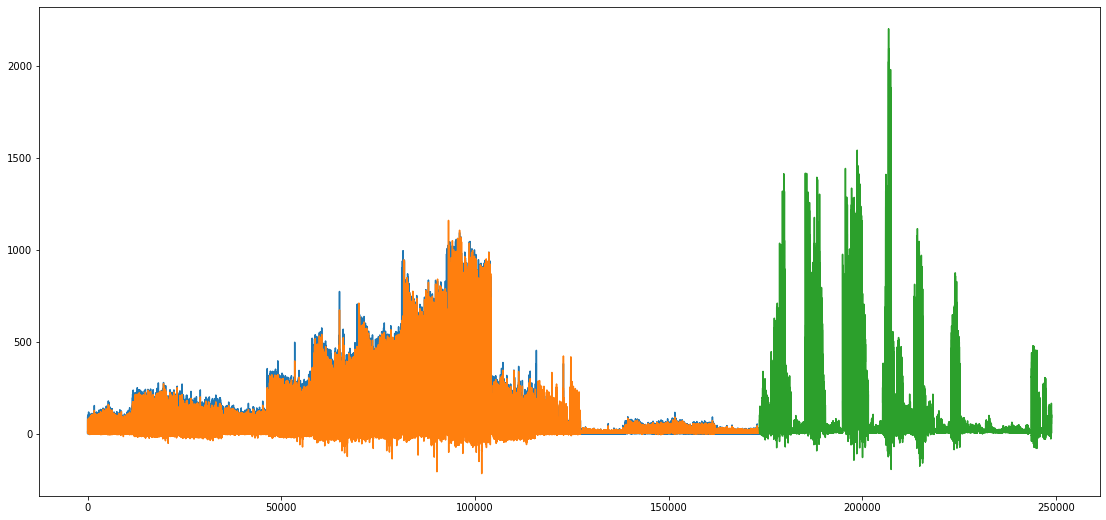

In [163]:
fig, ax = subplots(1, 1, figsize=(19, 9))
ax_reshape = [ax]

ax_reshape[0].plot(range(len(y_train)), y_train[('region', 'lag_plus_1')].values)
ax_reshape[0].plot(range(len(y_train_pred)), y_train_pred)

ax_reshape[0].plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred)



### Вывод:
* визуально ничего не понятно, так как здесь собраны все ряды всех регионов

### выберем один регион

In [164]:
df_train_result = df_train[[('region', 'id'), ('region', 'lag_plus_1')]].copy()
df_train_result['pred'] = y_train_pred
df_train_result = df_train_result[df_train_result[('region', 'id')] == empire_state_building_region]
df_train_result

Empty DataFrame
Columns: [(region, id), (region, lag_plus_1), (pred, )]
Index: []

In [165]:
df_test_result = df_test[[('region', 'id'), ('region', 'lag_plus_1')]].copy()
df_test_result['pred'] = y_pred
df_test_result = df_test_result[df_test_result[('region', 'id')] == empire_state_building_region]
df_test_result

region                    pred
                         id lag_plus_1             
tpep_pickup_datetime                               
2016-04-30 23:00:00    1231      881.0   797.573303
2016-05-01 00:00:00    1231      713.0   669.412842
2016-05-01 01:00:00    1231      533.0   473.862701
2016-05-01 02:00:00    1231      418.0   354.824249
2016-05-01 03:00:00    1231      353.0   261.988770
...                     ...        ...          ...
2016-05-31 13:00:00    1231     1009.0   868.437317
2016-05-31 14:00:00    1231      814.0   644.903198
2016-05-31 15:00:00    1231      748.0   716.875244
2016-05-31 16:00:00    1231      879.0   902.145020
2016-05-31 17:00:00    1231     1093.0  1100.129395

[739 rows x 3 columns]

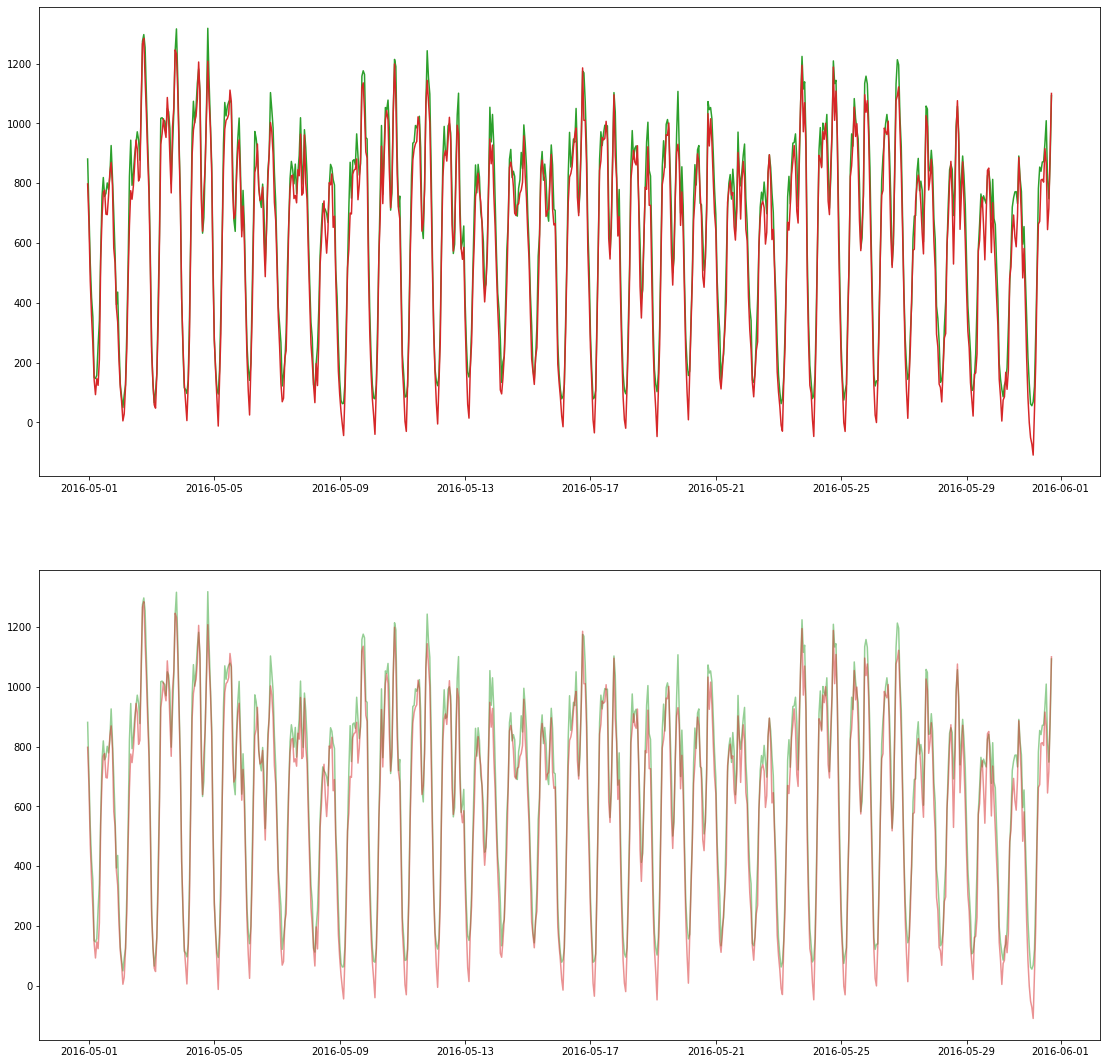

In [166]:
fig, ax = subplots(2, 1, figsize=(19, 19))
ax_reshape = ax.reshape(-1)

ax_reshape[0].plot(df_train_result[('region', 'lag_plus_1')])
ax_reshape[0].plot(df_train_result[('pred', '')])

ax_reshape[0].plot(df_test_result[('region', 'lag_plus_1')])
ax_reshape[0].plot(df_test_result[('pred', '')])


max_len = 1000

ax_reshape[1].plot(df_train_result[('region', 'lag_plus_1')][-max_len:], alpha=0.5)
ax_reshape[1].plot(df_train_result[('pred', '')][-max_len:], alpha=0.5)

ax_reshape[1].plot(df_test_result[('region', 'lag_plus_1')][:max_len], alpha=0.5)
ax_reshape[1].plot(df_test_result[('pred', '')][:max_len], alpha=0.5)


In [167]:
# # сохраненные гипер-параметры после перебора по сетке

# Lasso
# {0: {'best_score': 26.9850915843787,
#   'best_params': {'alpha': 1,
#    'tol': 0.0001,
#    'normalize': False,
#    'selection': 'random'},
#   'best_estimator': Lasso(alpha=1, selection='random')},
#  1: {'best_score': 42.5848898685642,
#   'best_params': {'alpha': 1,
#    'tol': 0.0001,
#    'normalize': False,
#    'selection': 'cyclic'},
#   'best_estimator': Lasso(alpha=1)},
#  2: {'best_score': 51.22004324581977,
#   'best_params': {'alpha': 1,
#    'tol': 0.0001,
#    'normalize': False,
#    'selection': 'random'},
#   'best_estimator': Lasso(alpha=1, selection='random')},
#  3: {'best_score': 53.99450243060681,
#   'best_params': {'alpha': 1,
#    'tol': 0.0001,
#    'normalize': False,
#    'selection': 'cyclic'},
#   'best_estimator': Lasso(alpha=1)},
#  4: {'best_score': 52.64427726954412,
#   'best_params': {'alpha': 1,
#    'tol': 0.0001,
#    'normalize': False,
#    'selection': 'cyclic'},
#   'best_estimator': Lasso(alpha=1)},
#  5: {'best_score': 48.96232540595154,
#   'best_params': {'alpha': 1,
#    'tol': 0.0001,
#    'normalize': False,
#    'selection': 'cyclic'},
#   'best_estimator': Lasso(alpha=1)}}

# Ridge
# {'alpha': 0.01, 'solver': 'svd'}
# 11.787872
# {'tol': 1e-07, 'solver': 'lsqr'}
# 11.734804

In [168]:


param_grid = {
    Lasso: {
        'alpha': 
    #         [10**i for i in range(-5, 3)], 
            [0.01], 
        'tol': 
    #         [10**i for i in range(-5, 1)],
            [10**-4],
        'normalize': [
            False, 
    #         True,
        ],
        'selection': [
    #         'cyclic', 
            'random',
        ],
    },
    
    Ridge: {
        'alpha': 
#             [10**i for i in range(-3, 3)], 
            [0.01], 
        'tol': 
#             [10**i for i in range(-5, 1)],
            [10**-7],
        'normalize': [
            False, 
#             True,
        ],
        'solver': [
#             'auto', 
            'svd', 
#             'cholesky', 
#             'lsqr', 
#             'sparse_cg', 'sag', 'saga',
        ],
    },
    
    DecisionTreeRegressor: {
    },
    
    RandomForestRegressor: {
    },
    
    GradientBoostingRegressor: {        
    },
    
    AdaBoostRegressor: {
    },
    
    LinearSVR: {
    },
    
}

len(list(it.product(*[param_grid[model_class][p] for p in param_grid[model_class]])))


1

In [169]:
print(list(it.product(param_grid[model_class])))

[('alpha',), ('tol',), ('normalize',), ('selection',)]


In [170]:
%%time

warnings.filterwarnings('ignore')

models = {}

if __model_rows is None:
    max_len = len(X_train)
else:
    max_len = __model_rows
    
for n_model in range(N_pred):
    print(n_model)
    
    models[n_model] = {}
    
    if __use_1_model:
        models[n_model]['best_params'] = None
        models[n_model]['best_score'] = None
        models[n_model]['best_estimator'] = model_default
        continue

    column_name_current = f'lag_plus_{n_model + 1}'
        
    models[n_model]['best_score'] = None
    
    for param_set in it.product(*[param_grid[model_class][p] for p in param_grid[model_class]]):

        try:
            current_params = {param_name: param_set[i] for i, param_name in enumerate(param_grid[model_class])}
            print(current_params)

            model_current = model_class(**current_params)

            model_current.fit(X_train[:max_len], y_train[('region', column_name_current)][:max_len])

            y_pred = model_current.predict(X_test_05[:max_len])

            current_score = mean_absolute_error(y_test_05[('region', column_name_current)], y_pred)
            print(current_score)

            if (models[n_model]['best_score'] is None) or (models[n_model]['best_score'] > current_score):
                models[n_model]['best_params'] = current_params
                models[n_model]['best_score'] = current_score
                models[n_model]['best_estimator'] = model_current

        except Exception as e:
            print(f'parameters:{current_params}, exception:{e}', )
            continue

    print(models[n_model])
            
warnings.filterwarnings('default')

models

# средне... - lasso
# Wall time: 3min 28s - Ridge
# DecisionTreeRegressor
# too much - RandomForestRegressor
# too much - GradientBoostingRegressor
# too much - AdaBoostRegressor
# too much - LinearSVR


0
1
2
3
4
5
Wall time: 19.2 ms
Parser   : 106 ms


{0: {'best_params': None, 'best_score': None, 'best_estimator': Lasso()},
 1: {'best_params': None, 'best_score': None, 'best_estimator': Lasso()},
 2: {'best_params': None, 'best_score': None, 'best_estimator': Lasso()},
 3: {'best_params': None, 'best_score': None, 'best_estimator': Lasso()},
 4: {'best_params': None, 'best_score': None, 'best_estimator': Lasso()},
 5: {'best_params': None, 'best_score': None, 'best_estimator': Lasso()}}

In [171]:
for n_model in range(N_pred):
    print(max(abs(models[n_model]['best_estimator'].coef_)))

1.0452594
1.0452594
1.0452594
1.0452594
1.0452594
1.0452594


d:\_Work\обучение\Coursera\_env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### подготовка данных для подсчета результата

In [172]:
R = 102
history_len = 739

In [173]:
n_04_31_hours = 1 # (2016.04.30 23:00)
n_full_days_hours = 30 * 24 # (2016.05.01 00:00 .. 2016.05.30 23:00)
n_05_31_hours = 18 # (2016.05.31 00:00 .. 17:00)

n_total_hours_05 = n_04_31_hours + n_full_days_hours + n_05_31_hours
print(f'n_total_hours={n_total_hours_05}')

n_pred = 6

n_total_hours_pred = n_total_hours_05 * n_pred
print(f'n_total_hours_pred={n_total_hours_pred}')

n_zones = 102

n_total_hours_zones = n_total_hours_05 * n_zones
print(f'n_total_hours_zones={n_total_hours_zones}')

n_total_hours_pred_zones = n_total_hours_pred * n_zones
print(f'n_total_hours_pred_zones={n_total_hours_pred_zones}')


n_total_hours=739
n_total_hours_pred=4434
n_total_hours_zones=75378
n_total_hours_pred_zones=452268


In [174]:
n_05_31_hours = 1 # (2016.05.31 23:00)
n_full_days_hours = 29 * 24 # (2016.06.01 00:00 .. 2016.06.29 23:00)
n_06_30_hours = 18 # (2016.06.30 00:00 .. 17:00)

n_total_hours_06 = n_05_31_hours + n_full_days_hours + n_06_30_hours
print(f'n_total_hours={n_total_hours_06}')

n_pred = 6

n_total_hours_pred = n_total_hours_06 * n_pred
print(f'n_total_hours_pred={n_total_hours_pred}')

n_zones = 102

n_total_hours_zones = n_total_hours_06 * n_zones
print(f'n_total_hours_zones={n_total_hours_zones}')

n_total_hours_pred_zones = n_total_hours_pred * n_zones
print(f'n_total_hours_pred_zones={n_total_hours_pred_zones}')

print(f'437580 - n_total_hours_pred_zones={437580 - n_total_hours_pred_zones}')



n_total_hours=715
n_total_hours_pred=4290
n_total_hours_zones=72930
n_total_hours_pred_zones=437580
437580 - n_total_hours_pred_zones=0


In [175]:
regions_102 

array([1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132,
       1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182,
       1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229, 1230,
       1231, 1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280,
       1281, 1282, 1283, 1284, 1285, 1286, 1287, 1326, 1327, 1331, 1332,
       1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377, 1378, 1380,
       1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431,
       1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1480, 1482, 1483,
       1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734, 1783, 2068, 2069,
       2118, 2119, 2168])

In [176]:
start_date_time = dt.datetime.strptime('2016-05-31 23:00:00', "%Y-%m-%d %H:%M:%S")

history_end_2016_06 = [start_date_time + dt.timedelta(hours = hours_n) for hours_n in range(n_total_hours_06)]

len(history_end_2016_06), history_end_2016_06[0], history_end_2016_06[-1]

(715,
 datetime.datetime(2016, 5, 31, 23, 0),
 datetime.datetime(2016, 6, 30, 17, 0))

### собственно функция расчета


In [177]:
def calc_score_df(y_pred, y_true):
    score = 0

    for pred_n in range(len(y_pred)):  
        score += abs(y_pred[pred_n] - y_true[pred_n]).sum()
                
    return score / (len(y_pred[0]) * n_pred)


### проверка расчетов на нулевых данных

In [178]:
y_test_0 = y_test_05.copy()
y_test_0.loc[:,:] = 0
y_test_0

region                                              \
                     lag_plus_1 lag_plus_2 lag_plus_3 lag_plus_4 lag_plus_5   
tpep_pickup_datetime                                                          
2016-04-30 23:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-01 00:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-01 01:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-01 02:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-01 03:00:00         0.0        0.0        0.0        0.0        0.0   
...                         ...        ...        ...        ...        ...   
2016-05-31 13:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-31 14:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-31 15:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-31 16:00:00         0.0        0.0        0.0        0.0        0.0   
2016-05-31 17:00:00         0.0        0.0        0.0        0.0        0.0   

                                 
                     lag_plus_6  
tpep_pickup_datetime             
2016-04-30 23:00:00         0.0  
2016-05-01 00:00:00         0.0  
2016-05-01 01:00:00         0.0  
2016-05-01 02:00:00         0.0  
2016-05-01 03:00:00         0.0  
...                         ...  
2016-05-31 13:00:00         0.0  
2016-05-31 14:00:00         0.0  
2016-05-31 15:00:00         0.0  
2016-05-31 16:00:00         0.0  
2016-05-31 17:00:00         0.0  

[75378 rows x 6 columns]

In [179]:
calc_score_df(y_test_0.values.T, y_test_05.values.T)

d:\_Work\обучение\Coursera\_env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


151.04925619323058

In [180]:
calc_score_df(y_test_05.values.T, y_test_05.values.T)

0.0

# постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу: 
$Q_{may} =\frac1{R* 739* 6} \sum\limits_{r=1}^{R} \sum_{T=2016.04.30 23:00}^{2016.05.31 17:00} \sum_{i=1}^6 \left| \hat{y}^r_{T|T+i} - y^r_{T+i} \right|$


* оценки прогнозов регрессии предыдущего занятия:
    * расчет по моей функции = 13.6

в оценках прогнозов этого занятия - в комментариях оставил историю того, как менялись результаты при добавлении разных блоков данных

In [181]:
%%time

y_pred_05 = []

for n_model in range(N_pred):
    y_pred_05.append(models[n_model]['best_estimator'].predict(X_test_05))
    
y_pred_05

Wall time: 1.16 s


[array([ 72.42241 ,  46.258484,  20.557554, ..., 103.36801 ,  93.54973 ,
         90.10449 ], dtype=float32),
 array([ 72.42241 ,  46.258484,  20.557554, ..., 103.36801 ,  93.54973 ,
         90.10449 ], dtype=float32),
 array([ 72.42241 ,  46.258484,  20.557554, ..., 103.36801 ,  93.54973 ,
         90.10449 ], dtype=float32),
 array([ 72.42241 ,  46.258484,  20.557554, ..., 103.36801 ,  93.54973 ,
         90.10449 ], dtype=float32),
 array([ 72.42241 ,  46.258484,  20.557554, ..., 103.36801 ,  93.54973 ,
         90.10449 ], dtype=float32),
 array([ 72.42241 ,  46.258484,  20.557554, ..., 103.36801 ,  93.54973 ,
         90.10449 ], dtype=float32)]

In [182]:
df_test_result = df_test[('region', 'id')].to_frame()

for n_model in range(N_pred):
    df_test_result[('prediction', n_model)] = y_pred_05[n_model]
    
df_test_result


d:\_Work\обучение\Coursera\_env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


region  prediction                                      \
                         id           0           1           2           3   
tpep_pickup_datetime                                                          
2016-04-30 23:00:00    1075   72.422409   72.422409   72.422409   72.422409   
2016-05-01 00:00:00    1075   46.258484   46.258484   46.258484   46.258484   
2016-05-01 01:00:00    1075   20.557554   20.557554   20.557554   20.557554   
2016-05-01 02:00:00    1075   16.492979   16.492979   16.492979   16.492979   
2016-05-01 03:00:00    1075   12.066627   12.066627   12.066627   12.066627   
...                     ...         ...         ...         ...         ...   
2016-05-31 13:00:00    2168   96.528397   96.528397   96.528397   96.528397   
2016-05-31 14:00:00    2168  117.759811  117.759811  117.759811  117.759811   
2016-05-31 15:00:00    2168  103.368011  103.368011  103.368011  103.368011   
2016-05-31 16:00:00    2168   93.549728   93.549728   93.549728   93.549728   
2016-05-31 17:00:00    2168   90.104492   90.104492   90.104492   90.104492   

                                              
                               4           5  
tpep_pickup_datetime                          
2016-04-30 23:00:00    72.422409   72.422409  
2016-05-01 00:00:00    46.258484   46.258484  
2016-05-01 01:00:00    20.557554   20.557554  
2016-05-01 02:00:00    16.492979   16.492979  
2016-05-01 03:00:00    12.066627   12.066627  
...                          ...         ...  
2016-05-31 13:00:00    96.528397   96.528397  
2016-05-31 14:00:00   117.759811  117.759811  
2016-05-31 15:00:00   103.368011  103.368011  
2016-05-31 16:00:00    93.549728   93.549728  
2016-05-31 17:00:00    90.104492   90.104492  

[75378 rows x 7 columns]

### оценка прогнозов 

In [183]:
y_pred_05 = np.array(y_pred_05)
# y_pred_05[y_pred_05 < 0].sum()

d:\_Work\обучение\Coursera\_env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [184]:
y_pred_05[y_pred_05 < 0] = 0
# y_pred_05

In [185]:
calc_score_df(y_pred_05, y_test_05.values.T)

# первая колонка - результат укороченного расчета (5_000 данных), вторая - полный прогон

# 58.32 # 13.6 - предыдущий прогноз (Lasso)
# 59.88 #       - Ridge 
# 59.02 #       + праздники (Ridge)
# 64.77 #       + near lags
#       # 13.59 - гипер-параметры (Ridge)
#       # 13.48 - Lasso без пассажиров
#       # 13.47 - Lasso с количеством пассажиров


58.32755163973573

### Итого по прогнозам на май 2016:
* было: 13.6
* стало 13.48

# Переобучите итоговые модели на данных до мая 2016 включительно, постройте прогнозы на июнь для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в уже знакомом вам формате: geoID, histEndDay, histEndHour, step, y

### оценки прогнозов регрессии предыдущего занятия:
* расчет по моей функции = 26.14
* submission на kaggle = 26.14734

In [186]:
X_train_06 = pd.concat([X_train, X_test_05])
X_train_06.shape

(248883, 454)

In [187]:
y_train_06 = pd.concat([y_train, y_test_05])
y_train_06.shape

(248883, 6)

### прогнозы моделей

In [188]:
%%time

warnings.filterwarnings('ignore')

y_pred_06 = []

if __model_rows is None:
    max_len = len(X_train)
else:
    max_len = __model_rows

for n_model in tqdm.tqdm(range(N_pred)):
    column_name_current = f'lag_plus_{n_model + 1}'
    models[n_model]['best_estimator'].fit(X_train_06[:max_len], y_train_06[('region', column_name_current)][:max_len])
    y_pred_06.append(models[n_model]['best_estimator'].predict(X_val_06))
    
warnings.filterwarnings('default')

y_pred_06

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:07<00:00,  1.23s/it]

Wall time: 7.81 s


[array([11.790825 ,  6.0641894, -5.468343 , ..., 54.79174  , 47.799282 ,
        66.07086  ], dtype=float32),
 array([  2.4136217,  -5.0758114, -12.324121 , ...,  58.971893 ,
         69.54372  ,  89.154045 ], dtype=float32),
 array([ -7.258007, -12.461151,  -9.100746, ...,  72.91806 ,  89.39902 ,
        111.09781 ], dtype=float32),
 array([-14.170277,  -9.535864,   7.120365, ...,  93.464355, 113.20181 ,
        119.8613  ], dtype=float32),
 array([-10.868441,   7.381797,  18.711357, ..., 114.575806, 114.1322  ,
         97.75571 ], dtype=float32),
 array([ 8.16558 , 26.102665, 46.761894, ..., 99.19253 , 96.94811 ,
        80.727295], dtype=float32)]

In [189]:
y_pred_06 = np.array(y_pred_06)
y_pred_06[y_pred_06 < 0] = 0
y_pred_06

d:\_Work\обучение\Coursera\_env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[ 11.790825 ,   6.0641894,   0.       , ...,  54.79174  ,
         47.799282 ,  66.07086  ],
       [  2.4136217,   0.       ,   0.       , ...,  58.971893 ,
         69.54372  ,  89.154045 ],
       [  0.       ,   0.       ,   0.       , ...,  72.91806  ,
         89.39902  , 111.09781  ],
       [  0.       ,   0.       ,   7.120365 , ...,  93.464355 ,
        113.20181  , 119.8613   ],
       [  0.       ,   7.381797 ,  18.711357 , ..., 114.575806 ,
        114.1322   ,  97.75571  ],
       [  8.16558  ,  26.102665 ,  46.761894 , ...,  99.19253  ,
         96.94811  ,  80.727295 ]], dtype=float32)

### оценка прогноза

In [190]:
# y_val_06

In [191]:
df_val_result_06 = df_val[('region', 'id')].to_frame()

for n_model in range(N_pred):
    df_val_result_06[('prediction', n_model)] = y_pred_06[n_model]
    
df_val_result_06


region prediction                                     \
                         id          0          1           2           3   
tpep_pickup_datetime                                                        
2016-05-31 23:00:00    1075  11.790825   2.413622    0.000000    0.000000   
2016-06-01 00:00:00    1075   6.064189   0.000000    0.000000    0.000000   
2016-06-01 01:00:00    1075   0.000000   0.000000    0.000000    7.120365   
2016-06-01 02:00:00    1075   0.000000   0.000000    7.923253   16.514889   
2016-06-01 03:00:00    1075   0.000000   7.963900   17.406055   46.947887   
...                     ...        ...        ...         ...         ...   
2016-06-30 13:00:00    2168  45.503567  76.863548   68.082581   62.671654   
2016-06-30 14:00:00    2168  74.679733  69.185272   61.058594   77.999069   
2016-06-30 15:00:00    2168  54.791740  58.971893   72.918060   93.464355   
2016-06-30 16:00:00    2168  47.799282  69.543716   89.399017  113.201813   
2016-06-30 17:00:00    2168  66.070862  89.154045  111.097809  119.861298   

                                             
                               4          5  
tpep_pickup_datetime                         
2016-05-31 23:00:00     0.000000   8.165580  
2016-06-01 00:00:00     7.381797  26.102665  
2016-06-01 01:00:00    18.711357  46.761894  
2016-06-01 02:00:00    48.798923  71.260689  
2016-06-01 03:00:00    61.442204  67.130051  
...                          ...        ...  
2016-06-30 13:00:00    71.967361  82.729591  
2016-06-30 14:00:00    91.777512  95.074150  
2016-06-30 15:00:00   114.575806  99.192528  
2016-06-30 16:00:00   114.132202  96.948112  
2016-06-30 17:00:00    97.755707  80.727295  

[72930 rows x 7 columns]

In [193]:
calc_score_df(y_pred_06, y_val_06.values.T)

# 60.85 # 26.14 - предыдущая регрессия (Lasso)
# 40.89 # 26.10 - добавление данных за май в обучающую выборка для июня (Lasso)
# 51.0  #       - Ridge
# 49.2  #       + праздники (Ridge)
# 50.12 #       + лаги ближние
#       # 26.87 - гипер-параметры (Ridge)
#       # 25.97 - Lasso без пассажиров
#       # 25.98 - Lasso с количеством пассажиров


40.844620412267474

In [194]:
# %%time

# result_2016_06_pred = {}

# prediction_columns = [('prediction', n_model) for n_model in range(N_pred)]

# for region_index, region_n in tqdm.tqdm(enumerate(regions_102)):
#     result_2016_06_pred[region_n] = {}
    
#     for history_index, history_end in enumerate(history_end_2016_06):
#         result_2016_06_pred[region_n][history_end] = df_val_result_06[(df_val_result.index == history_end) & (df_val_result[('region', 'id')] == region_n)][prediction_columns].values[0]

# len(result_2016_06_pred)

0it [00:00, ?it/s]


NameError: name 'df_val_result' is not defined

In [195]:
# submission_6_07_Lasso = create_submission(result_2016_06_pred)
# submission_6_07_Lasso

,id,y


In [196]:
# submission_6_07_Lasso.to_csv('submission_6_07_Lasso.csv', header=True, index=None)

# # 26.14734 - предыдущая регрессия (Lasso)
# # 26.10 - добавление данных за май в обучающую выборка для июня (Lasso)
# # 27.06347 - Ridge
# # 26.98634 + праздники (Ridge)
# # 26.87 - гипер-параметры (Ridge)
# # 25.97335 - Lasso без пассажиров
# # 25.98374 - Lasso с количеством пассажиров


d:\_Work\обучение\Coursera\_env\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [212]:
df_val_result_06_save = df_val_result_06.reset_index()
df_val_result_06_save.columns = ['tpep_pickup_datetime', 'region', 'prediction_1', 'prediction_2', 'prediction_3', 'prediction_4', 'prediction_5', 'prediction_6']
df_val_result_06_save.to_csv('df_val_result_06_save.csv', header=True, index=False)

### Итого:
* расчет по моей функции
    * было: 26.14
    * стало 25.97
* submission на kaggle
    * было: 26.14734
    * стало 25.97335


# 6. Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

* не нашел, как сделать доступным свой submission
* вот ссылка https://www.kaggle.com/c/yellowtaxi/submissions, но это общий список всех открытых submission
* сделаю скрин-шот экрана :)

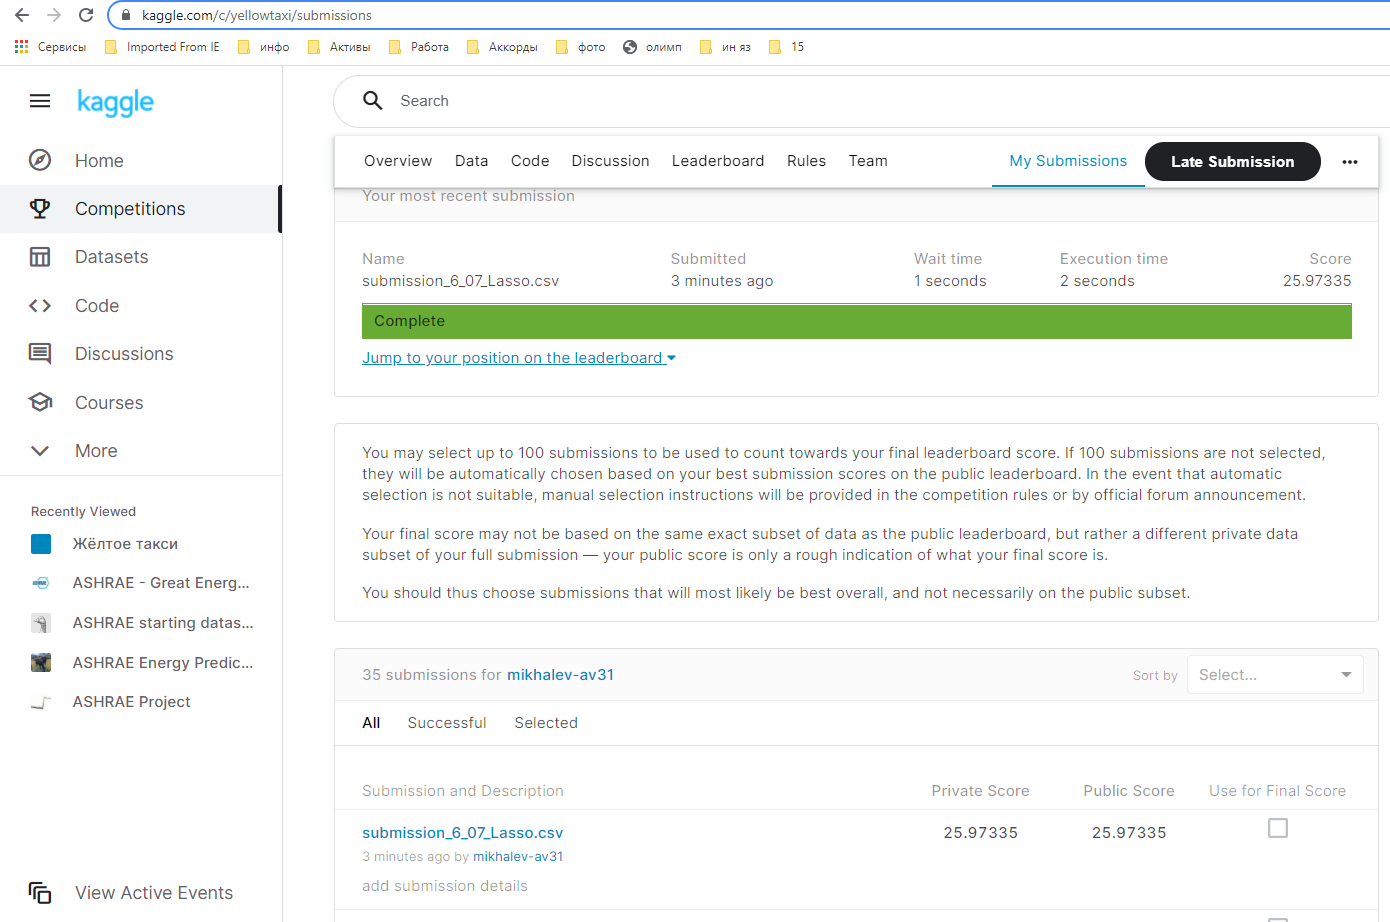